### Exploratory Data Analysis (EDA)

In this notebook, we will perform EDA to understand more about our dataset and the situation in Chicago.

In [1]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 14
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# others
import os
import re
import time
import datetime as datetime

### Import Data

In [2]:
# import clean data

df_train = pd.read_csv('./clean data/train_clean.csv')
df_test = pd.read_csv('./clean data/test_clean.csv')
df_weather = pd.read_csv('./clean data/weather_clean.csv')
df_spray = pd.read_csv('./clean data/spray_clean.csv')

street_map = gpd.read_file('./datasets/Chicago Boundaries/geo_export_d41dc94d-31ce-478c-902c-864695385885.shp')

As shown in the plot below, the dataset is highly imbalanced with most of data showing that there was no presence of the West Nile Virus. We had subsequently addressed this issue by oversampling from the minority dataset via SMOTE (Synthetic Minority Oversampling Technique).

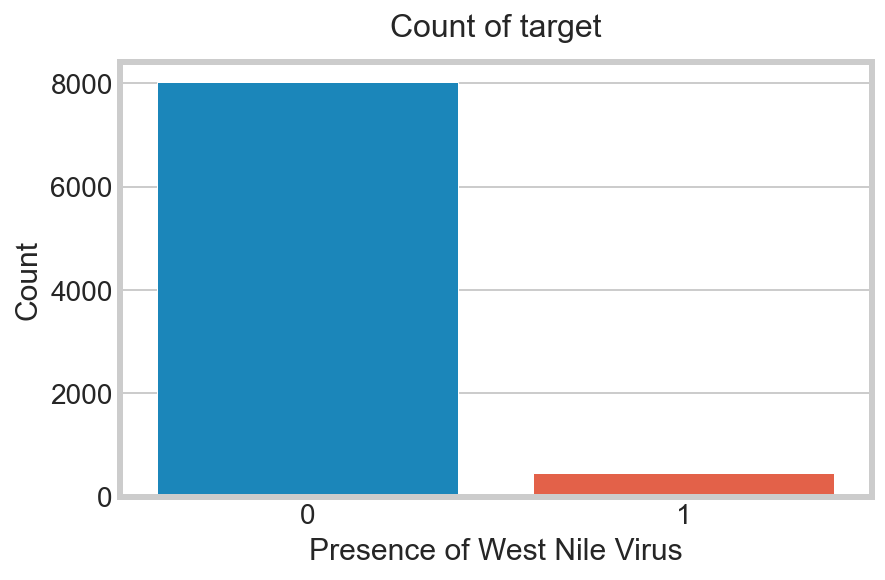

In [3]:
# The target is imbalanced, which will be taken care of before modelling is done.
sns.barplot(x=[0,1], y=df_train.wnvpresent.value_counts())
plt.xlabel('Presence of West Nile Virus', fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.tick_params(labelsize=14)
plt.title('Count of target',fontsize=16, y=1.03)
plt.show()


The countplot below shows that there is a spike in the number of mosquitos during the summer periods (i.e. July and August). This collaborates with our subsequent observation that the number of mosquitos and consequently the presence of the west nile virus is prevalent under high temperatures.

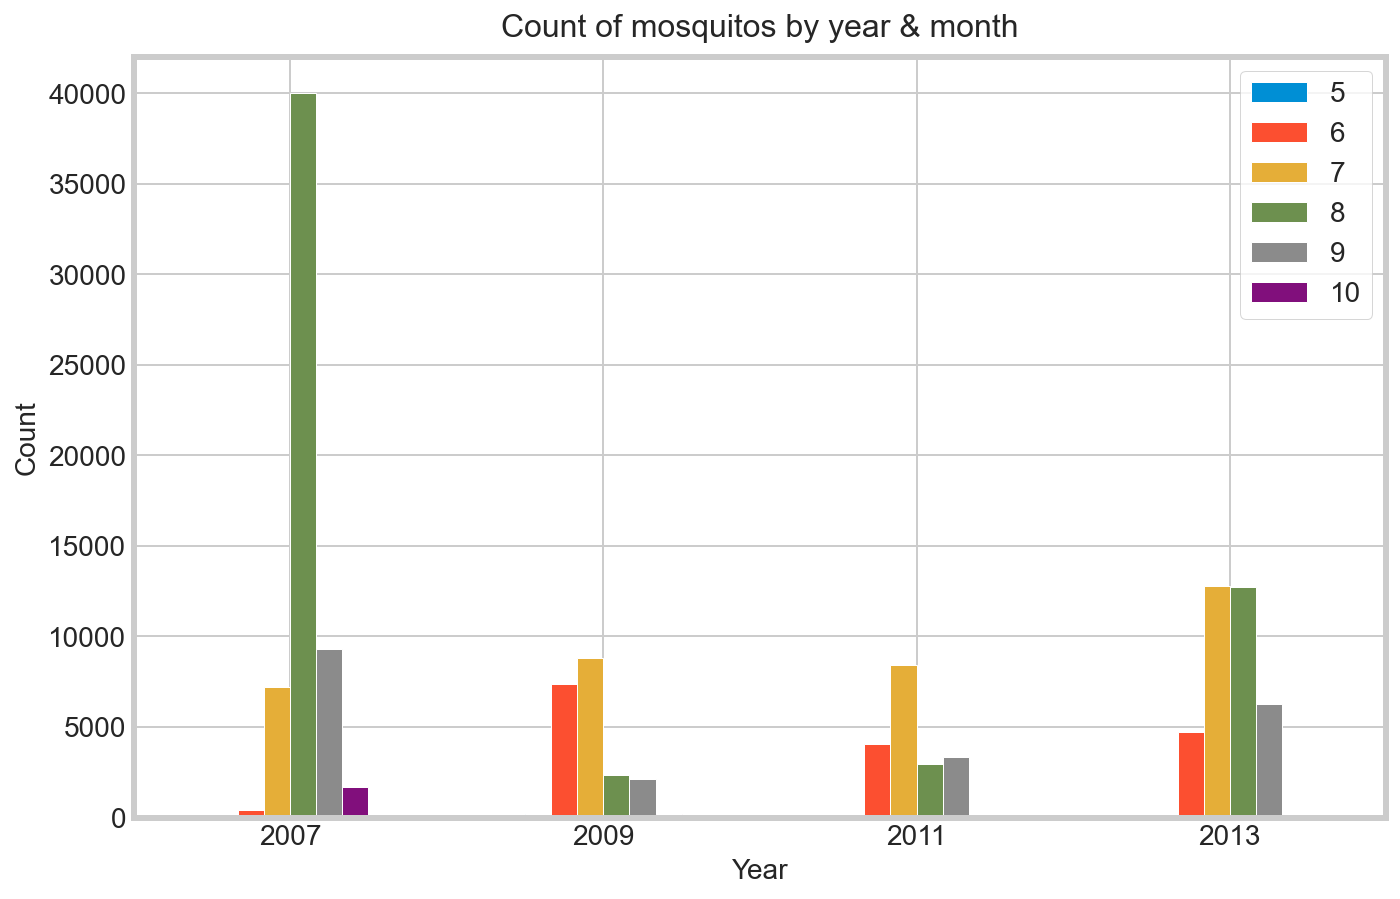

In [4]:
# Highest number of mosquitos caught in Jul, Aug
df_train.groupby(['year','month']).nummosquitos.sum().unstack(fill_value=0).plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitos by year & month', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

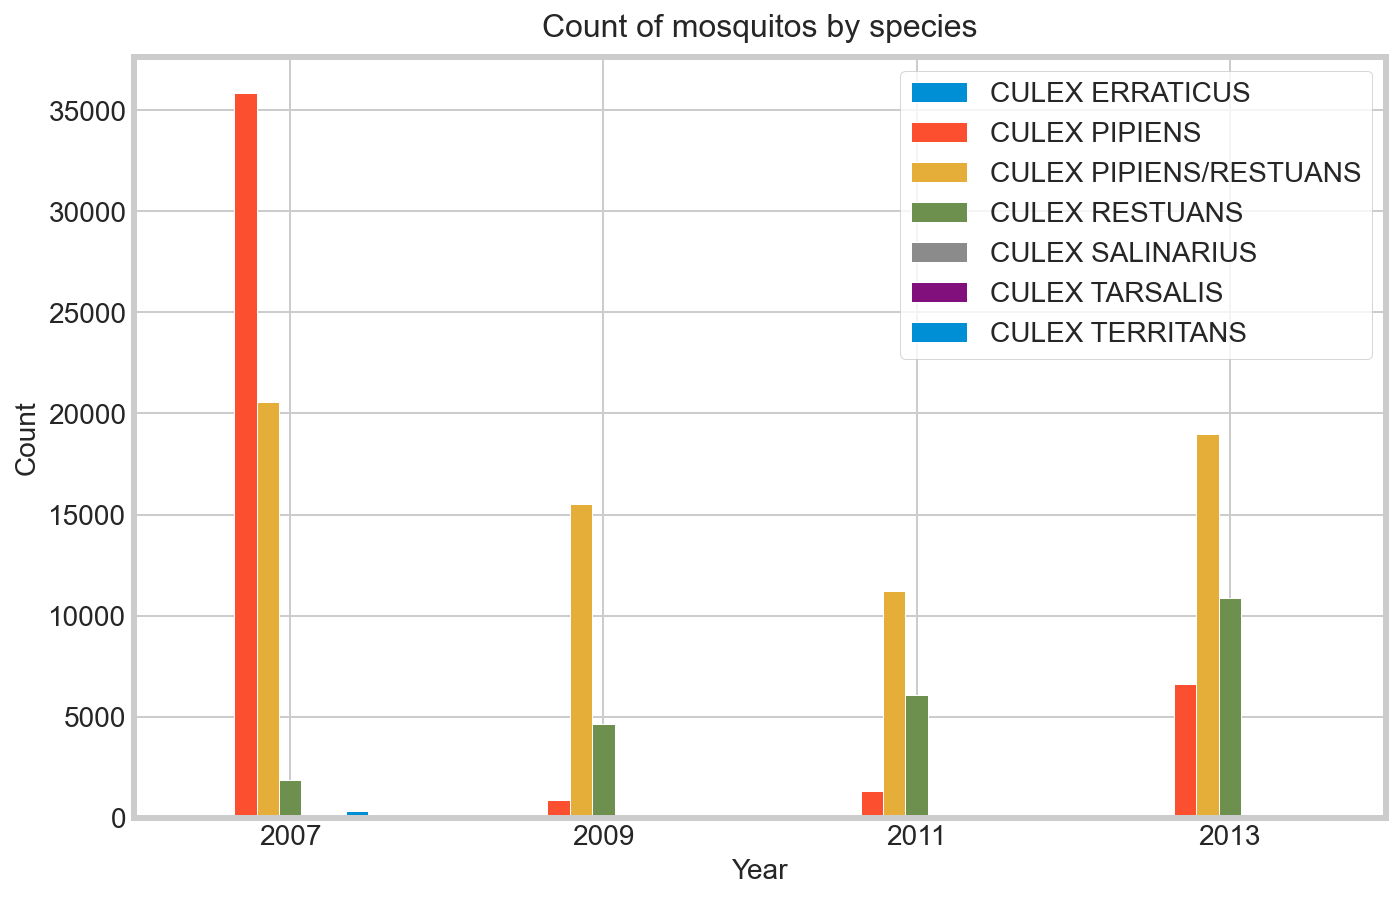

In [5]:
# Most common species of mosquitos caught are Culex Pipiens and Culex Restuans
# Proportion of each species are the same except for 2007
df_train.groupby(['year','species']).nummosquitos.sum().unstack(fill_value=0).plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitos by species', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

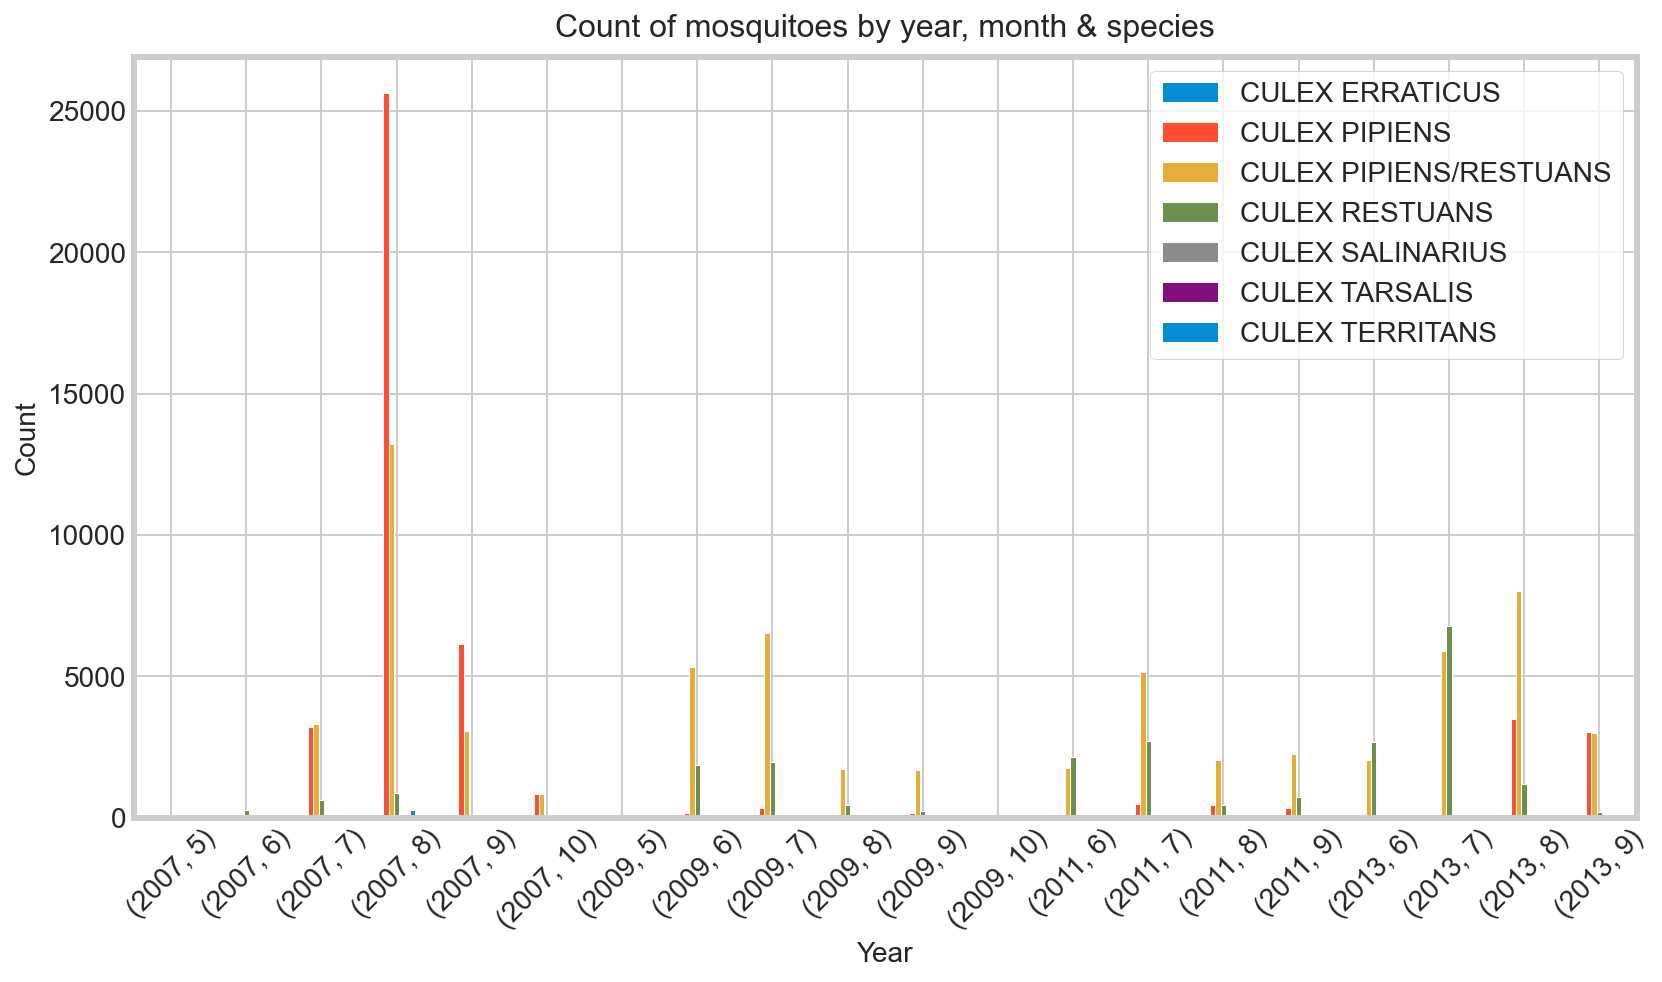

In [6]:
# not much insights to draw from this plot - to remove? 
df_train.groupby(['year','month', 'species']).nummosquitos.sum().unstack(fill_value=0).plot.bar(figsize=(12,7))
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitoes by year, month & species', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

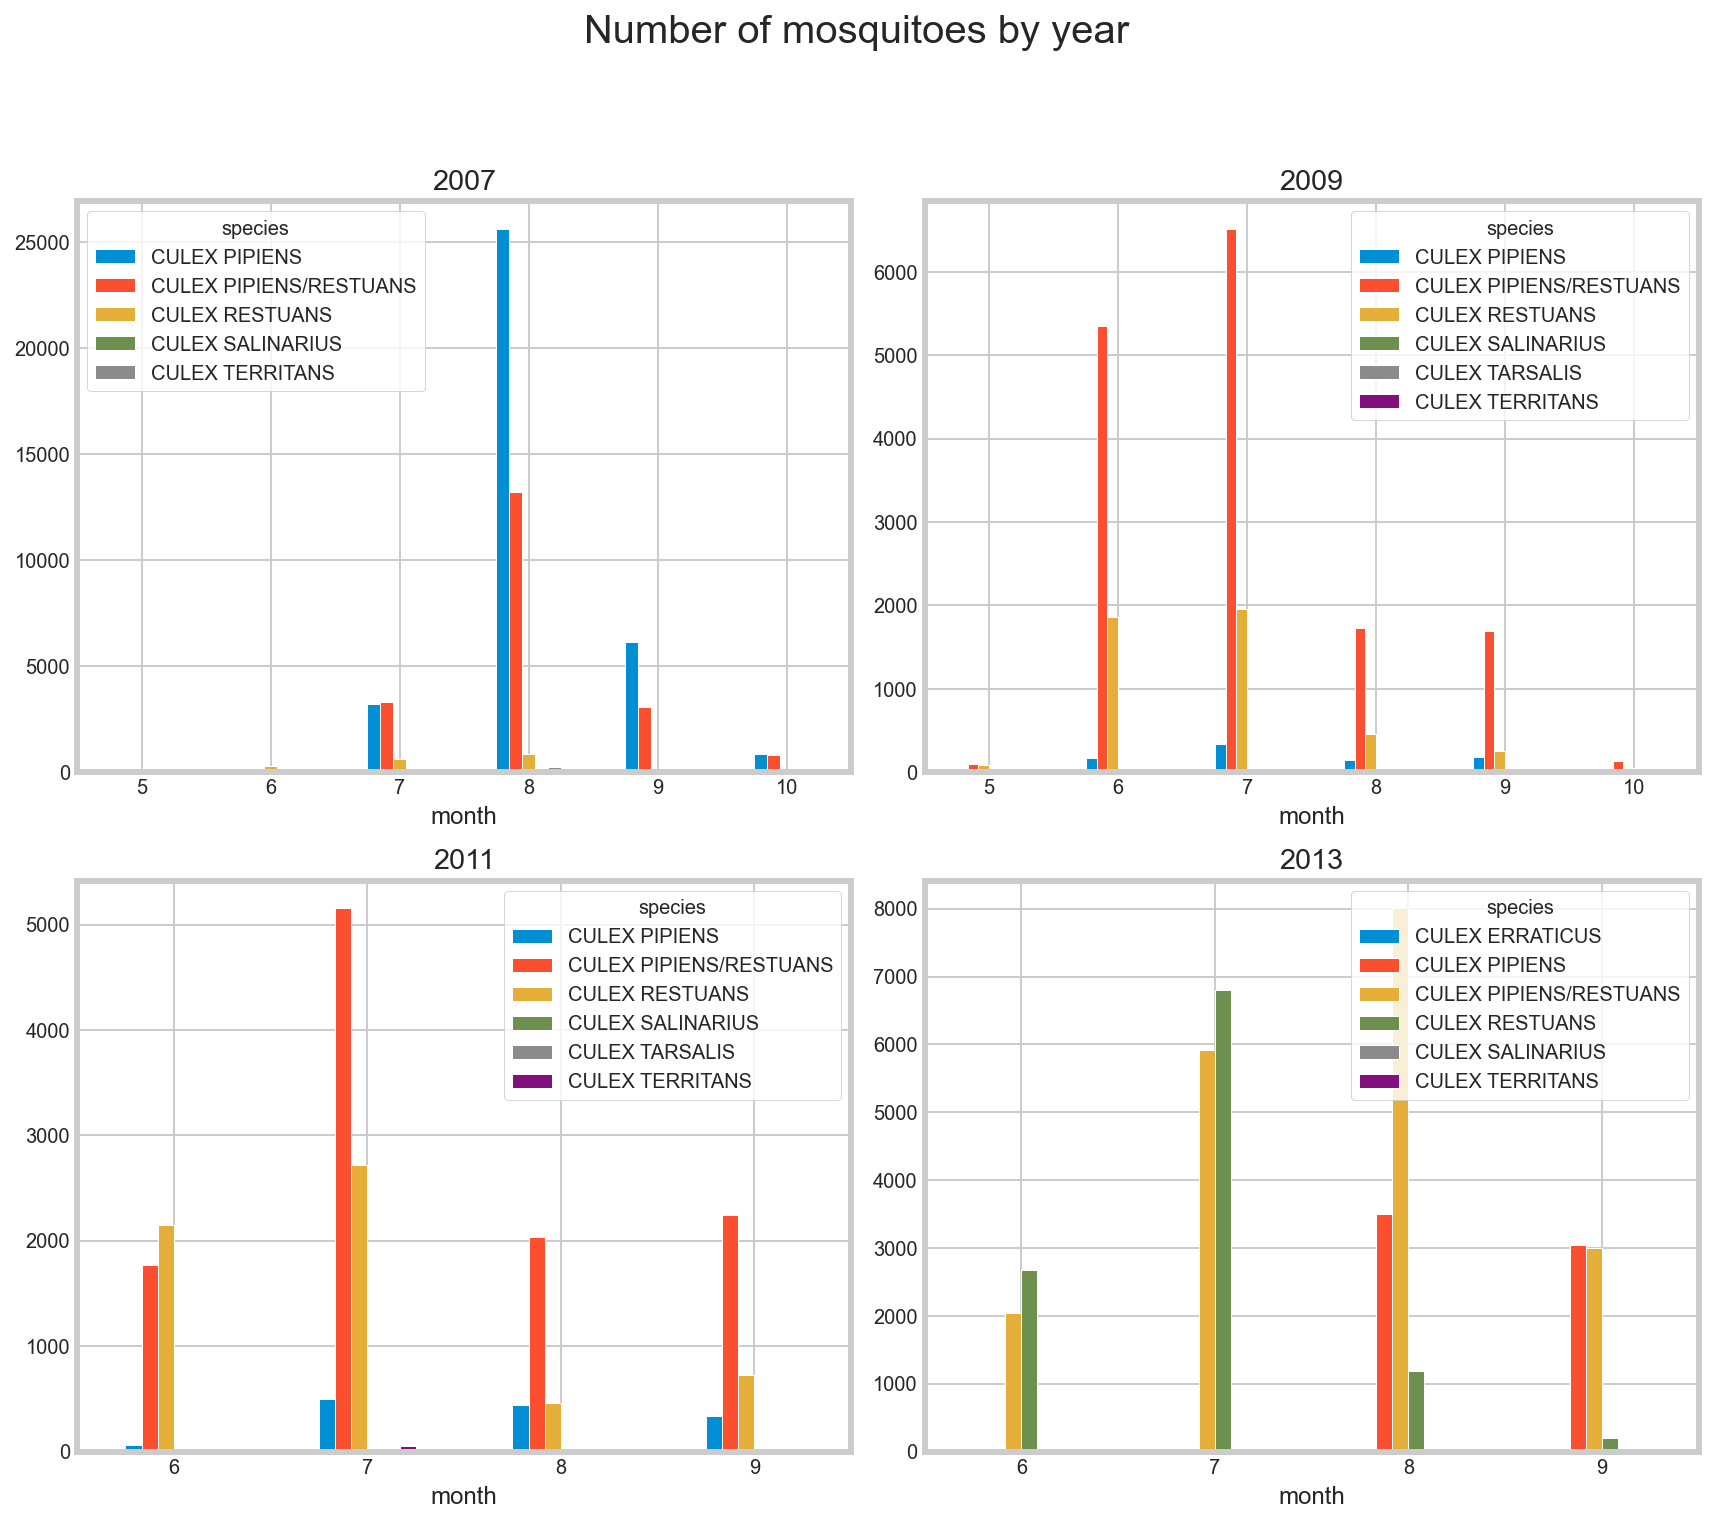

In [7]:
# same as above but can see the breakdown more clearly
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
ax = ax.ravel()
plt.suptitle('Number of mosquitoes by year', fontsize=20, y=1.05)
for i, y in enumerate(df_train.year.unique()):
    df_train[df_train['year']==y].groupby(['month', 'species']).nummosquitos.sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

Even though we witnessed the spike in the number of mosquitos during the July and August periods, the spike in presence of west nile virus only took place in the August and September periods. This suggests that there is a one month lag between the spike in number of mosquitos and presence of west nile virus. From a cost-benefit-analysis, it is in our interest to adopt a target approach and use our model to predict any spike in the number of mosquitos (as the presence of west nile virus will typically follow a month after). We can then focus our spraying efforts based on this projection and mitigate the spike in number of mosquitos.

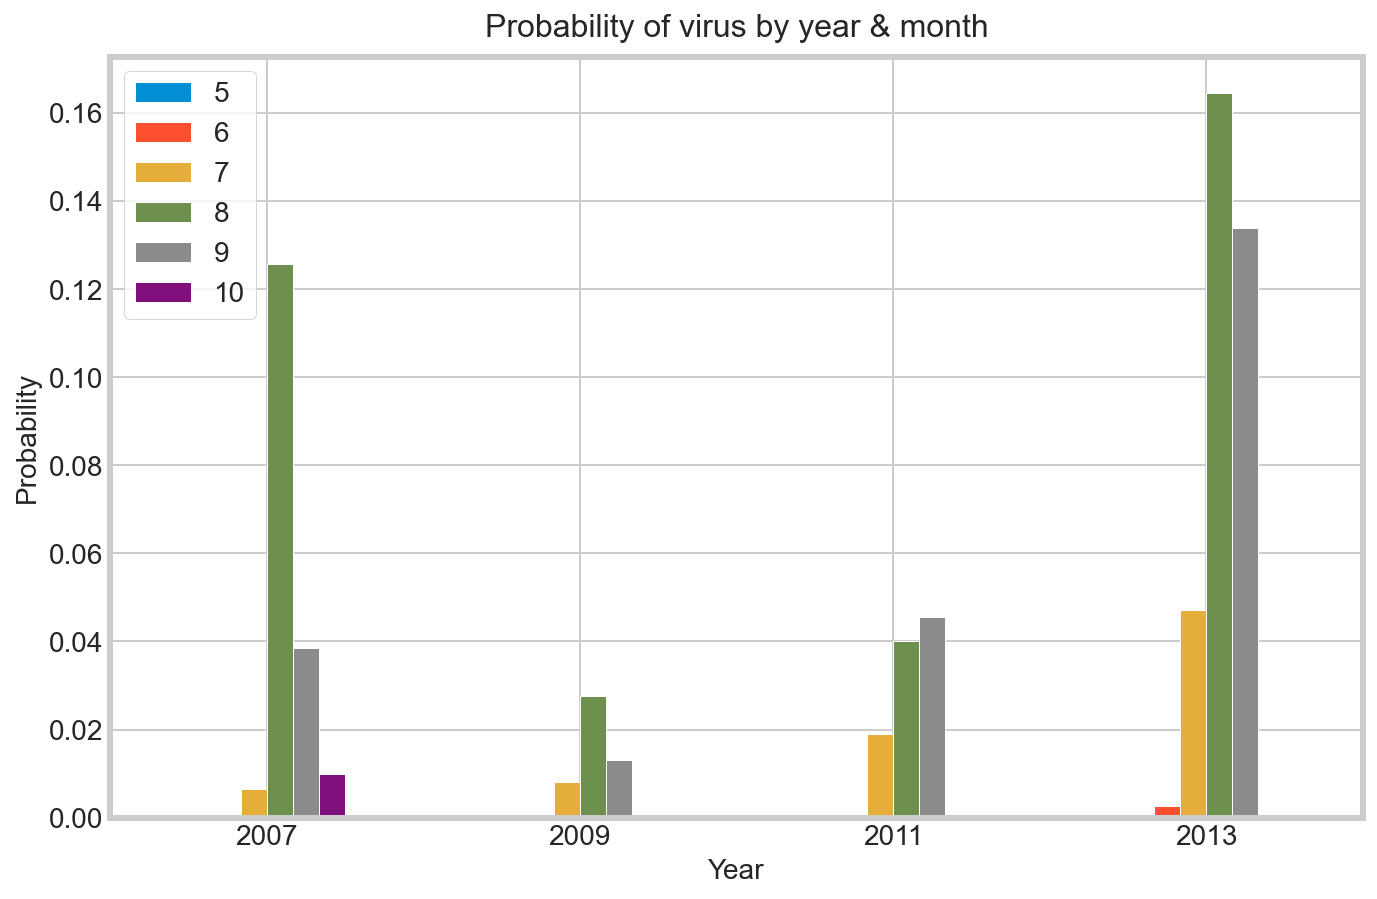

In [8]:
# Highest percentage of virus occuring in Aug, Sep which is a delay from the highest number of mosquitos
df_train.groupby(['year','month']).wnvpresent.mean().unstack(fill_value=0).plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Probability of virus by year & month', fontsize=16, y=1.01)
plt.ylabel('Probability', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

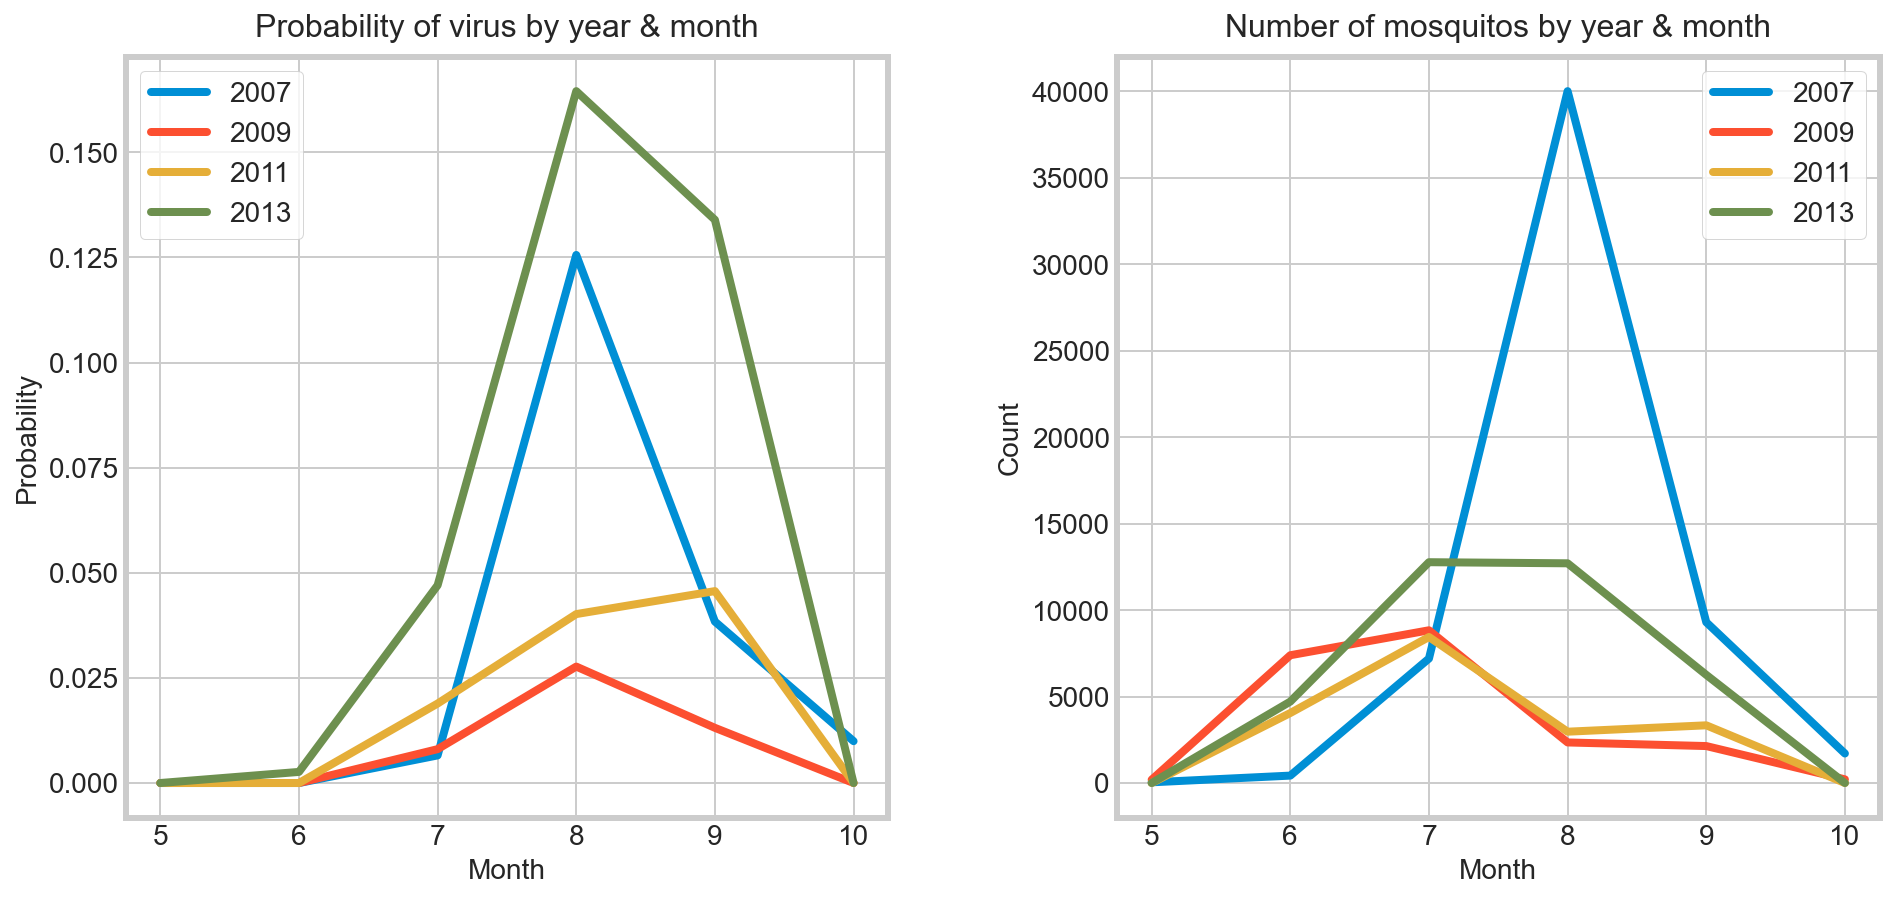

In [9]:
# Highest probability of virus in Aug except for 2011, where highest probability of virus was in Sep
# Higher number of mosquito does not indicate higher probability of virus 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()
df_train.groupby(['month', 'year']).wnvpresent.mean().unstack(fill_value=0).plot(ax=ax[0])
df_train.groupby(['month', 'year']).nummosquitos.sum().unstack(fill_value=0).plot(ax=ax[1])

ax[0].set_title('Probability of virus by year & month', fontsize=16, y=1.01)
ax[0].set_ylabel('Probability', fontsize=14)
ax[0].set_xlabel('Month',fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Number of mosquitos by year & month', fontsize=16, y=1.01)
ax[1].set_ylabel('Count', fontsize=14)
ax[1].set_xlabel('Month',fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(labelsize=14)

plt.subplots_adjust(wspace=0.3)

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


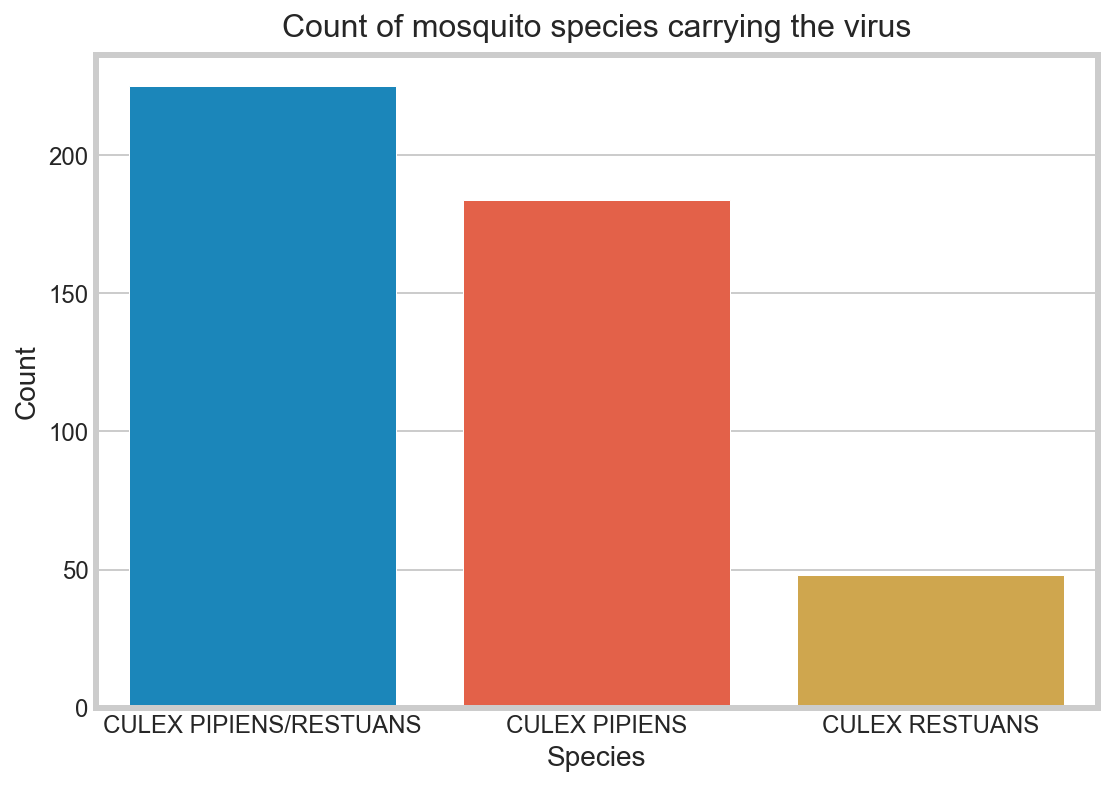

In [10]:
plt.figure(figsize=(8,6))
sns.countplot(df_train[df_train['wnvpresent']==1].species)
plt.title('Count of mosquito species carrying the virus', fontsize=16, y=1.01)
plt.tick_params(labelsize=12)
plt.xlabel('Species', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

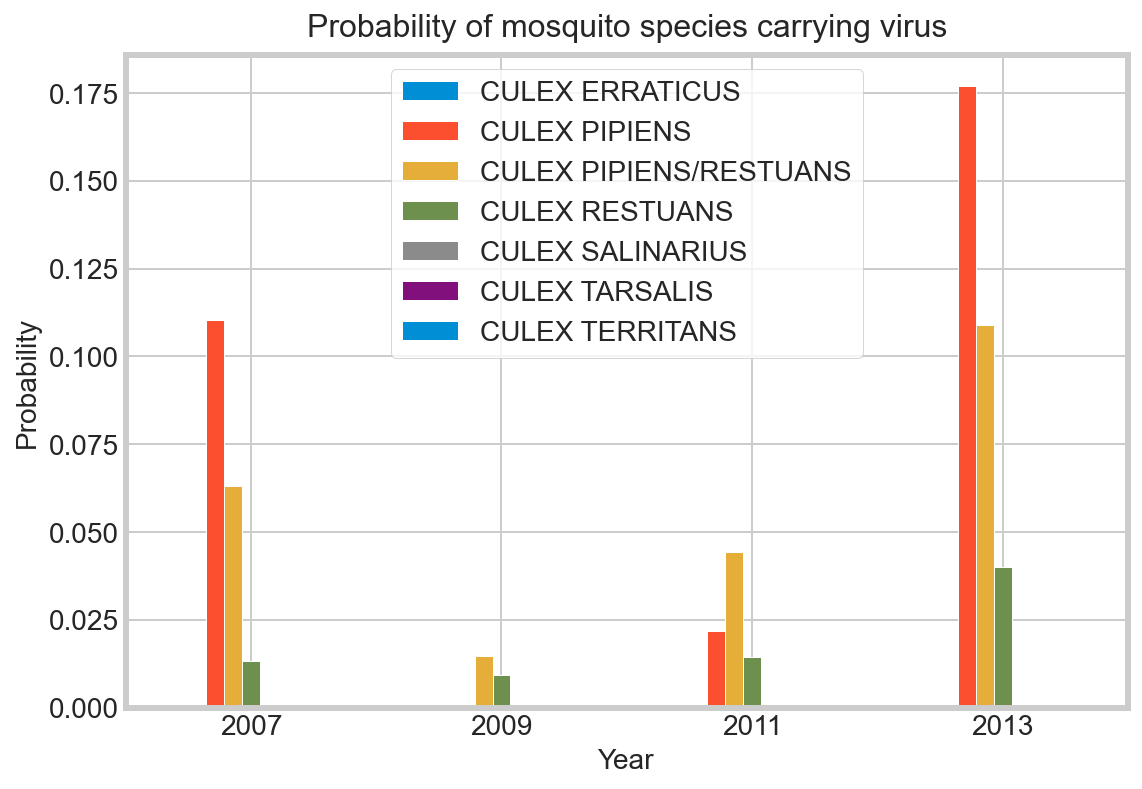

In [11]:
# Most common species of mosquitos caught are Culex Pipiens and Culex Restuans
# Proportion of each species are the same except for 2007
df_train.groupby(['year','species']).wnvpresent.mean().unstack(fill_value=0).plot.bar(figsize=(8,6))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Probability of mosquito species carrying virus', fontsize=16, y=1.01)
plt.ylabel('Probability', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

<AxesSubplot:xlabel='nummosquitos', ylabel='wnvpresent'>

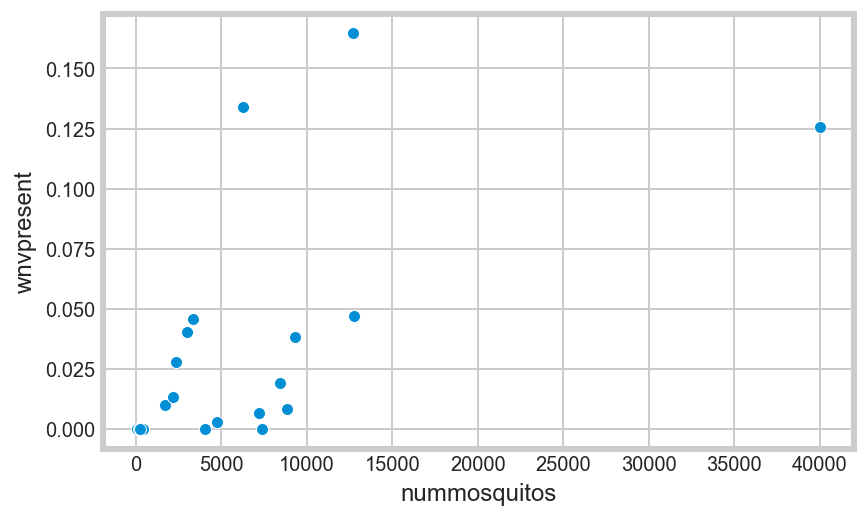

In [12]:
# looks like there is an outlier - to remove the graph?
sns.scatterplot(x=df_train.groupby(['year', 'month']).nummosquitos.sum(),
                y= df_train.groupby(['year', 'month']).wnvpresent.mean())

### Weather Data

In [52]:
df_weather.head()

station  tmax  tmin  tavg  depart  dewpoint  wetbulb  heat  cool  sunrise  \
0        1    83    50    67      14        51     56.0     0     2      448   
1        2    84    52    68      14        51     57.0     0     3      448   
2        1    59    42    51      -3        42     47.0    14     0      447   
3        2    60    43    52      -3        42     47.0    13     0      447   
4        1    66    46    56       2        40     48.0     9     0      446   

   ...  resultdir  avgspeed  year  month  day           sunrise_2  \
0  ...         27       9.2  2007      5    1 1900-01-01 04:48:00   
1  ...         25       9.6  2007      5    1 1900-01-01 04:48:00   
2  ...          4      13.4  2007      5    2 1900-01-01 04:47:00   
3  ...          2      13.4  2007      5    2 1900-01-01 04:47:00   
4  ...          7      11.9  2007      5    3 1900-01-01 04:46:00   

             sunset_2        daylight  daylight_2       date  
0 1900-01-01 18:49:00 0 days 14:01:00   14.016667 2007-05-01  
1 1900-01-01 18:49:00 0 days 14:01:00   14.016667 2007-05-01  
2 1900-01-01 18:50:00 0 days 14:03:00   14.050000 2007-05-02  
3 1900-01-01 18:50:00 0 days 14:03:00   14.050000 2007-05-02  
4 1900-01-01 18:51:00 0 days 14:05:00   14.083333 2007-05-03  

[5 rows x 25 columns]

In [13]:
print('year:')
print(df_weather['year'].unique())
print('')
print('month:')
print(df_weather['month'].unique())
print('')
print('day:')
print(df_weather['day'].unique())
print('')

year:
[2007 2008 2009 2010 2011 2012 2013 2014]

month:
[ 5  6  7  8  9 10]

day:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]



- We have weather data for 8 years from 2007 to 2014.
- Only 6 out of 12 months of data available (end spring, summer, early autumn).

In [14]:
temp_summary_table = pd.pivot_table(df_weather, values=['tmax','tmin','tavg'], index=['year', 'month'], aggfunc=np.mean)
temp_summary_table

tavg       tmax       tmin
year month                                 
2007 5      64.612903  75.758065  53.032258
     6      72.200000  81.433333  62.516667
     7      74.193548  83.177419  64.709677
     8      75.387097  83.048387  67.145161
     9      68.916667  79.200000  58.316667
     10     59.838710  68.387097  50.822581
2008 5      56.322581  66.129032  45.935484
     6      71.616667  81.016667  61.700000
     7      74.612903  84.112903  64.693548
     8      73.306452  81.774194  64.322581
     9      67.000000  75.383333  58.166667
     10     53.500000  61.870968  44.693548
2009 5      60.758065  70.677419  50.419355
     6      68.516667  77.183333  59.283333
     7      70.403226  78.629032  61.725806
     8      71.225806  79.225806  62.677419
     9      65.983333  74.066667  57.366667
     10     49.483871  55.483871  42.951613
2010 5      62.419355  71.193548  53.161290
     6      71.800000  80.216667  62.800000
     7      78.354839  87.080645  69.080645
     8      77.112903  85.451613  68.322581
     9      65.833333  74.383333  56.816667
     10     56.612903  66.790323  45.870968
2011 5      59.016129  68.354839  49.193548
     6      70.366667  79.516667  60.733333
     7      80.048387  88.967742  70.596774
     8      74.258065  82.612903  65.338710
     9      63.050000  70.216667  55.466667
     10     55.370968  64.887097  45.467742
2012 5      65.887097  75.935484  55.354839
     6      74.316667  84.816667  63.300000
     7      82.000000  91.564516  71.790323
     8      74.580645  84.209677  64.500000
     9      65.316667  74.783333  55.233333
     10     52.500000  60.887097  43.693548
2013 5      62.000000  71.741935  51.645161
     6      69.300000  78.333333  59.800000
     7      74.129032  82.225806  65.612903
     8      73.919355  82.887097  64.403226
     9      68.383333  77.716667  58.500000
     10     54.209677  62.822581  45.129032
2014 5      62.129032  72.193548  51.564516
     6      72.250000  81.600000  62.350000
     7      71.645161  80.354839  62.370968
     8      74.612903  82.532258  66.290323
     9      65.250000  74.416667  55.616667
     10     53.661290  61.548387  45.161290

In [50]:
df_yr_mth = df_weather.groupby(['year','month'])['tmax','tmin','tavg'].mean()
df_yr_mth = pd.DataFrame(df_yr_mth)
df_yr_mth

<ipython-input-50-ae6179b1361b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_yr_mth = df_weather.groupby(['year','month'])['tmax','tmin','tavg'].mean()


tmax       tmin       tavg
year month                                 
2007 5      75.758065  53.032258  64.612903
     6      81.433333  62.516667  72.200000
     7      83.177419  64.709677  74.193548
     8      83.048387  67.145161  75.387097
     9      79.200000  58.316667  68.916667
     10     68.387097  50.822581  59.838710
2008 5      66.129032  45.935484  56.322581
     6      81.016667  61.700000  71.616667
     7      84.112903  64.693548  74.612903
     8      81.774194  64.322581  73.306452
     9      75.383333  58.166667  67.000000
     10     61.870968  44.693548  53.500000
2009 5      70.677419  50.419355  60.758065
     6      77.183333  59.283333  68.516667
     7      78.629032  61.725806  70.403226
     8      79.225806  62.677419  71.225806
     9      74.066667  57.366667  65.983333
     10     55.483871  42.951613  49.483871
2010 5      71.193548  53.161290  62.419355
     6      80.216667  62.800000  71.800000
     7      87.080645  69.080645  78.354839
     8      85.451613  68.322581  77.112903
     9      74.383333  56.816667  65.833333
     10     66.790323  45.870968  56.612903
2011 5      68.354839  49.193548  59.016129
     6      79.516667  60.733333  70.366667
     7      88.967742  70.596774  80.048387
     8      82.612903  65.338710  74.258065
     9      70.216667  55.466667  63.050000
     10     64.887097  45.467742  55.370968
2012 5      75.935484  55.354839  65.887097
     6      84.816667  63.300000  74.316667
     7      91.564516  71.790323  82.000000
     8      84.209677  64.500000  74.580645
     9      74.783333  55.233333  65.316667
     10     60.887097  43.693548  52.500000
2013 5      71.741935  51.645161  62.000000
     6      78.333333  59.800000  69.300000
     7      82.225806  65.612903  74.129032
     8      82.887097  64.403226  73.919355
     9      77.716667  58.500000  68.383333
     10     62.822581  45.129032  54.209677
2014 5      72.193548  51.564516  62.129032
     6      81.600000  62.350000  72.250000
     7      80.354839  62.370968  71.645161
     8      82.532258  66.290323  74.612903
     9      74.416667  55.616667  65.250000
     10     61.548387  45.161290  53.661290

In [16]:
year_list = df_weather['year'].unique()
df_list = []

for year in year_list:
    df = df_yr_mth.loc[year]
    df_list.append(df)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


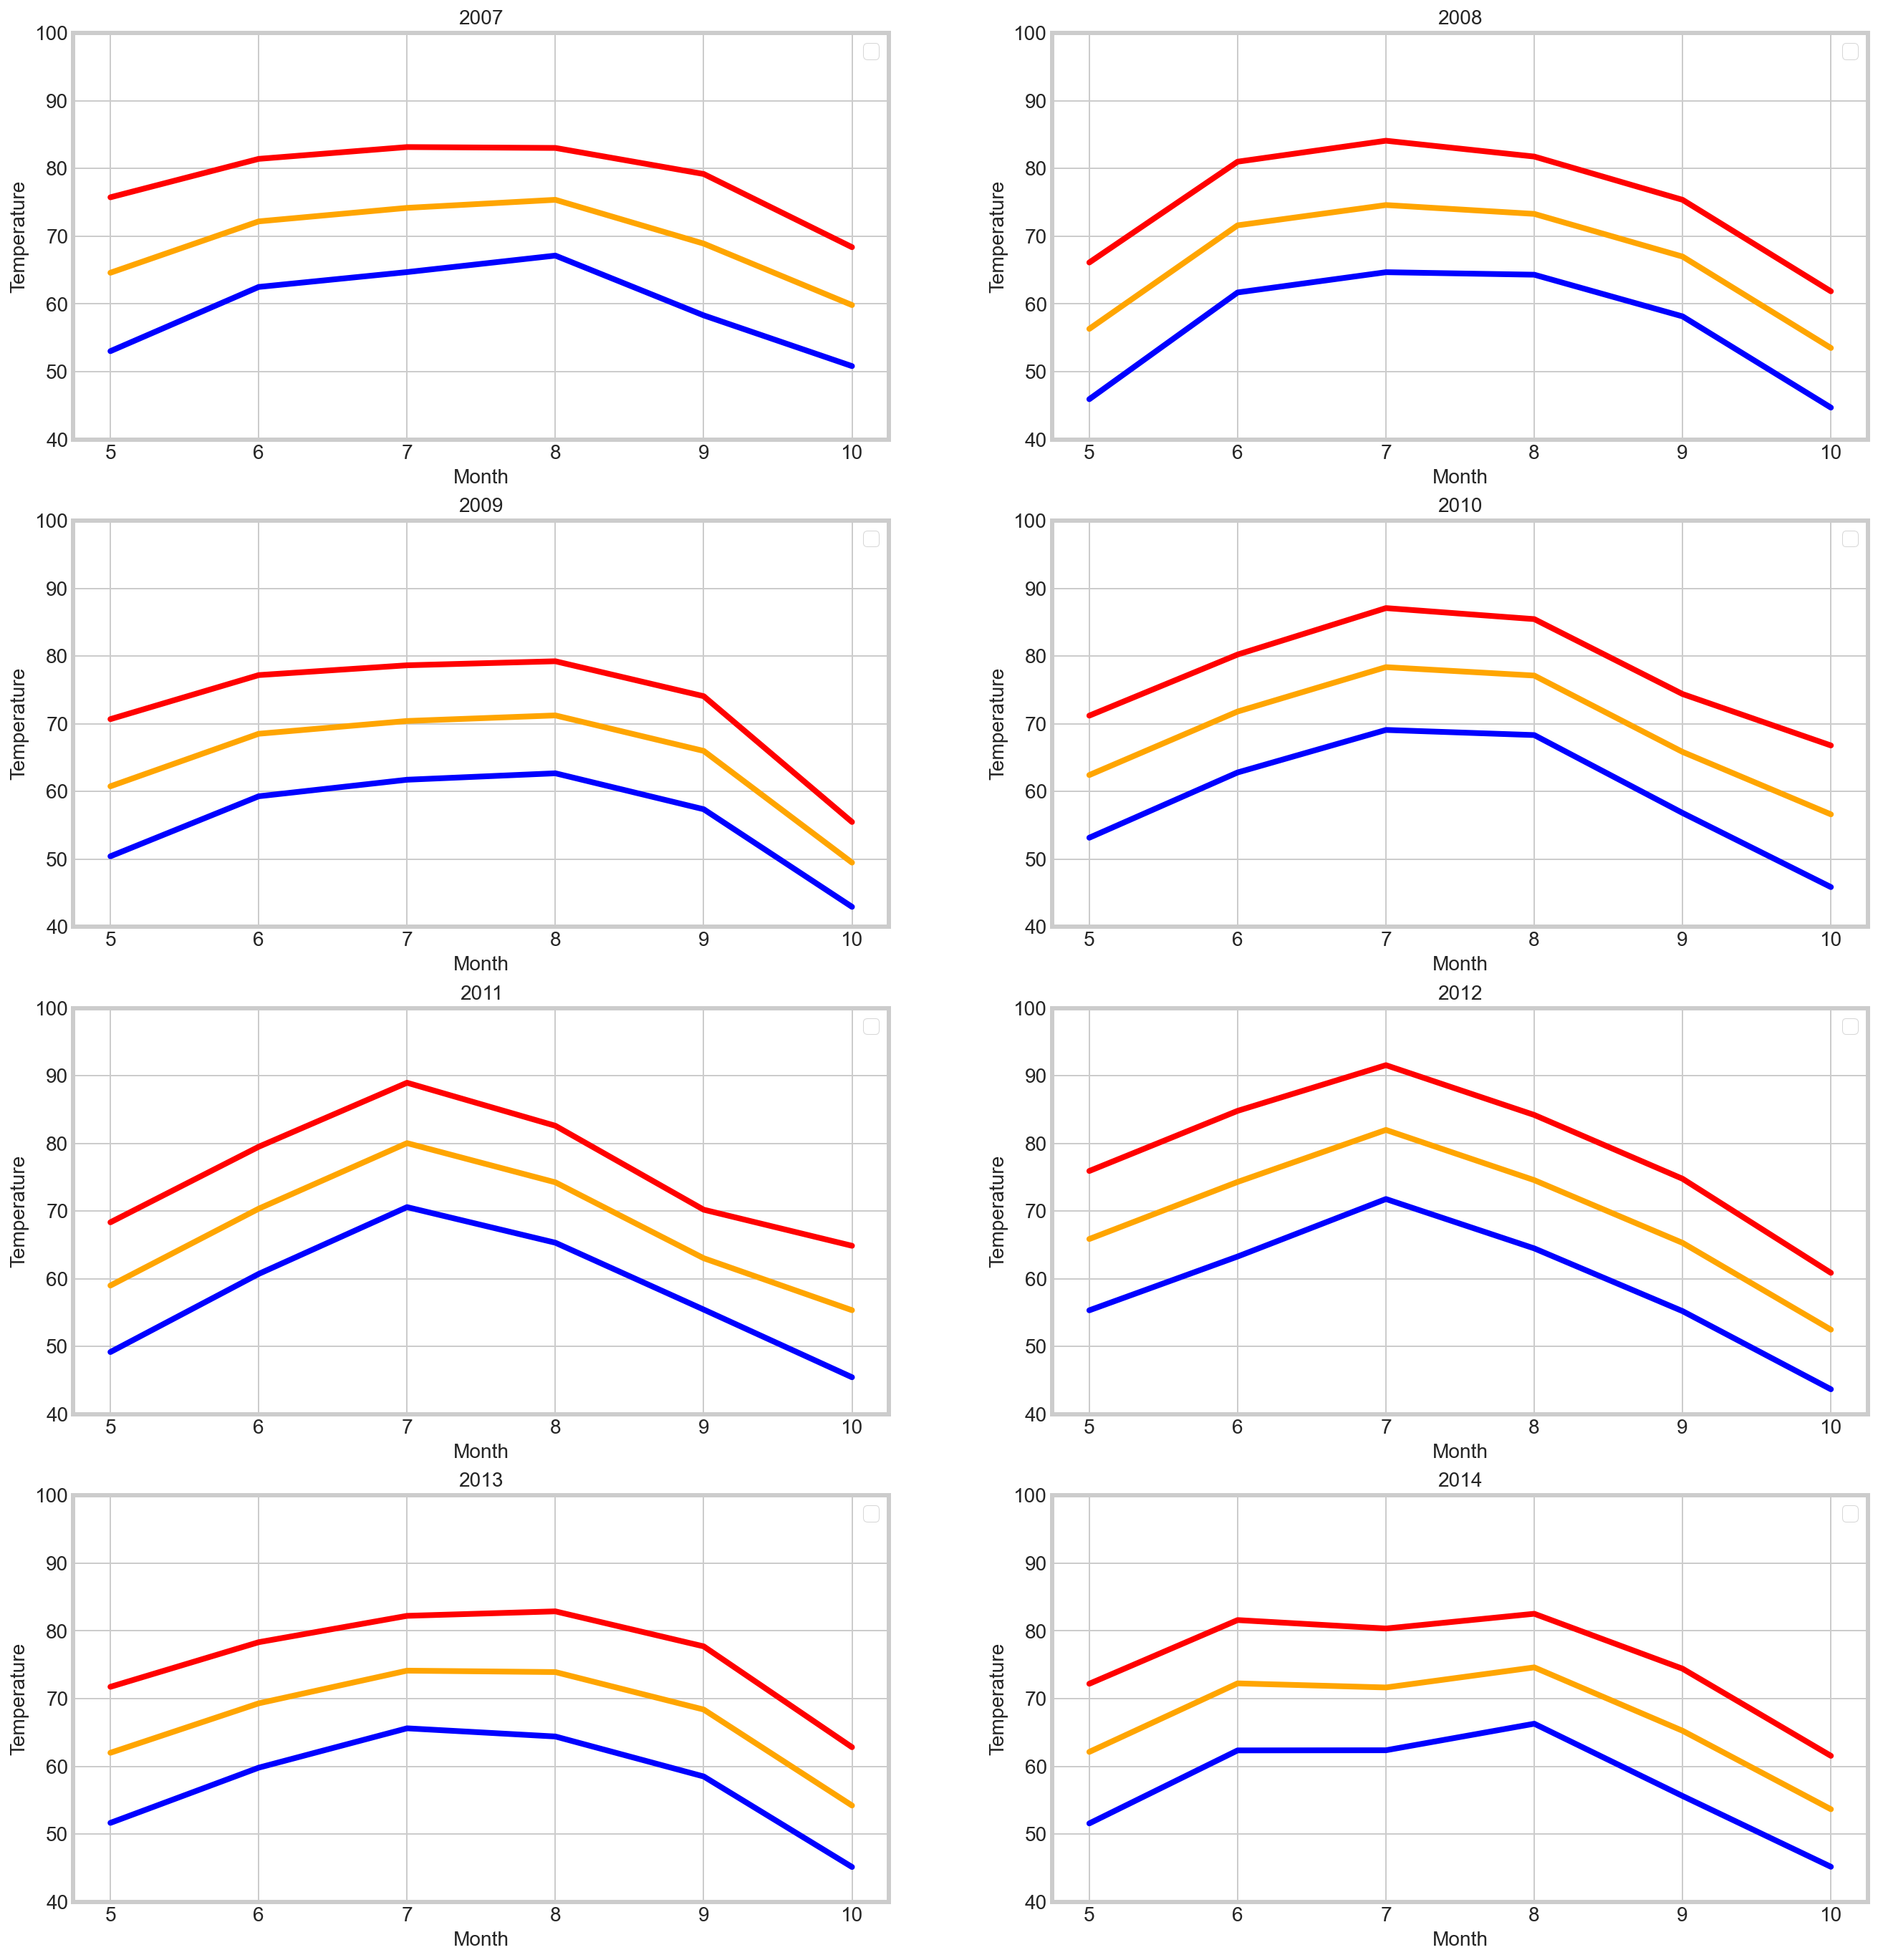

In [17]:
fig,axes = plt.subplots(4,2,figsize=(20,24))

for idx,df in enumerate(df_list):    
    
    row_idx = int(idx/2)
    col_idx = idx%2    
    #print(idx,row_idx,col_idx)    
      
    y = ['tmax','tmin','tavg']
    
    year = year_list[idx]  
    axes[row_idx,col_idx].set_title(year, fontsize=14)
    axes[row_idx,col_idx].set_ylim(40,100)
    axes[row_idx,col_idx].set_xlabel('Month', fontsize=14)
    axes[row_idx,col_idx].set_ylabel('Temperature', fontsize=14)
    axes[row_idx,col_idx].tick_params(labelsize=14)
    axes[row_idx,col_idx].legend(fontsize=14)

    sns.lineplot(data=df,x=df.index,y=y[0],ax=axes[row_idx,col_idx],color='red',markers=True)
    sns.lineplot(data=df,x=df.index,y=y[1],ax=axes[row_idx,col_idx],color='blue',markers=True)
    sns.lineplot(data=df,x=df.index,y=y[2],ax=axes[row_idx,col_idx],color='orange',markers=True)

As shown below, 2012 has the highest average temperature for 3 out of 6 months i.e. highest temperature for May, June and July. 2009 has the lowest average temperature for 4 out of 6 months i.e. highest temperature for June, July, August and October.

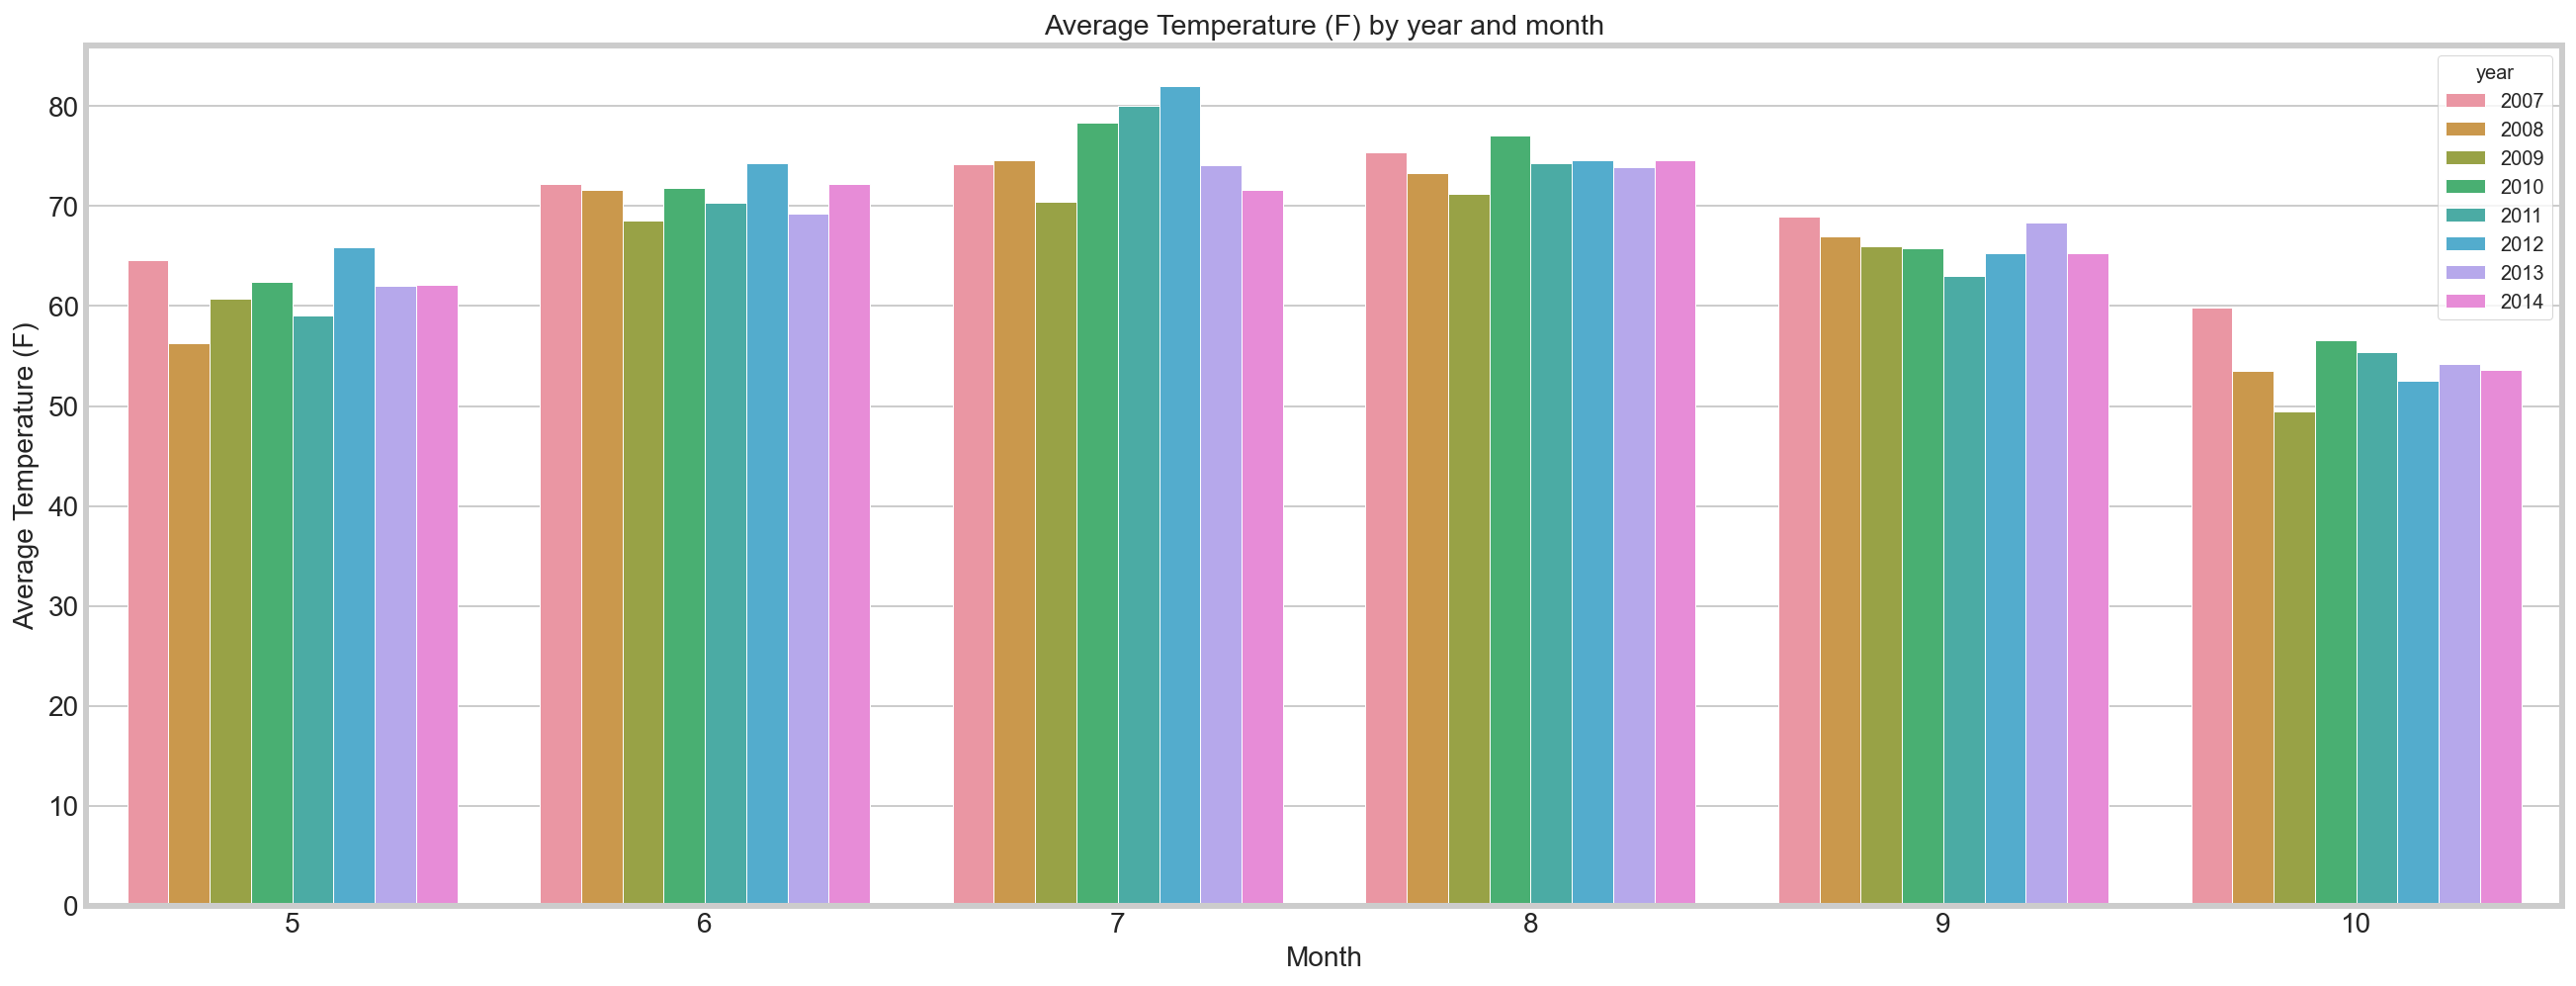

In [18]:
plt.figure(figsize=(20,8))

sns.barplot(data=df_weather,x='month',y='tavg',hue='year', ci=None)
plt.title('Average Temperature (F) by year and month')
plt.ylabel('Average Temperature (F)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.tick_params(labelsize=14)

In [19]:
# clean incorrect sunset time
# example: 1860 -> 1900

for idx,row in df_weather.iterrows():

    sunset = int(row['sunset'])
    sunset = str(sunset)
    #print(idx,sunset)
    
    if sunset[-2:] == '60':
        
        hour = int(sunset[:2])
        mins = int(sunset[-2:])
        
        mins = '00'
        hour += 1
        hour = str(hour)
        
        df_weather.at[idx,'sunset'] = hour + mins

In [20]:
df_weather['sunrise_2'] = pd.to_datetime(df_weather['sunrise'], format='%H%M')
df_weather['sunset_2'] = pd.to_datetime(df_weather['sunset'], format='%H%M')

df_weather['daylight'] = df_weather['sunset_2'] - df_weather['sunrise_2']
#df_weather['daylight_2'] = df_weather['daylight'].dt.total_seconds() / 3600

In [21]:
for idx,row in df_weather.iterrows():
    
    daylight = row['daylight']
    daylight = daylight.total_seconds() / 3600    
    df_weather.at[idx,'daylight_2'] = daylight

In [22]:
df_daylight = df_weather.groupby(['year','month'])['daylight_2'].mean()
df_daylight = pd.DataFrame(df_daylight)

<AxesSubplot:xlabel='month', ylabel='daylight_2'>

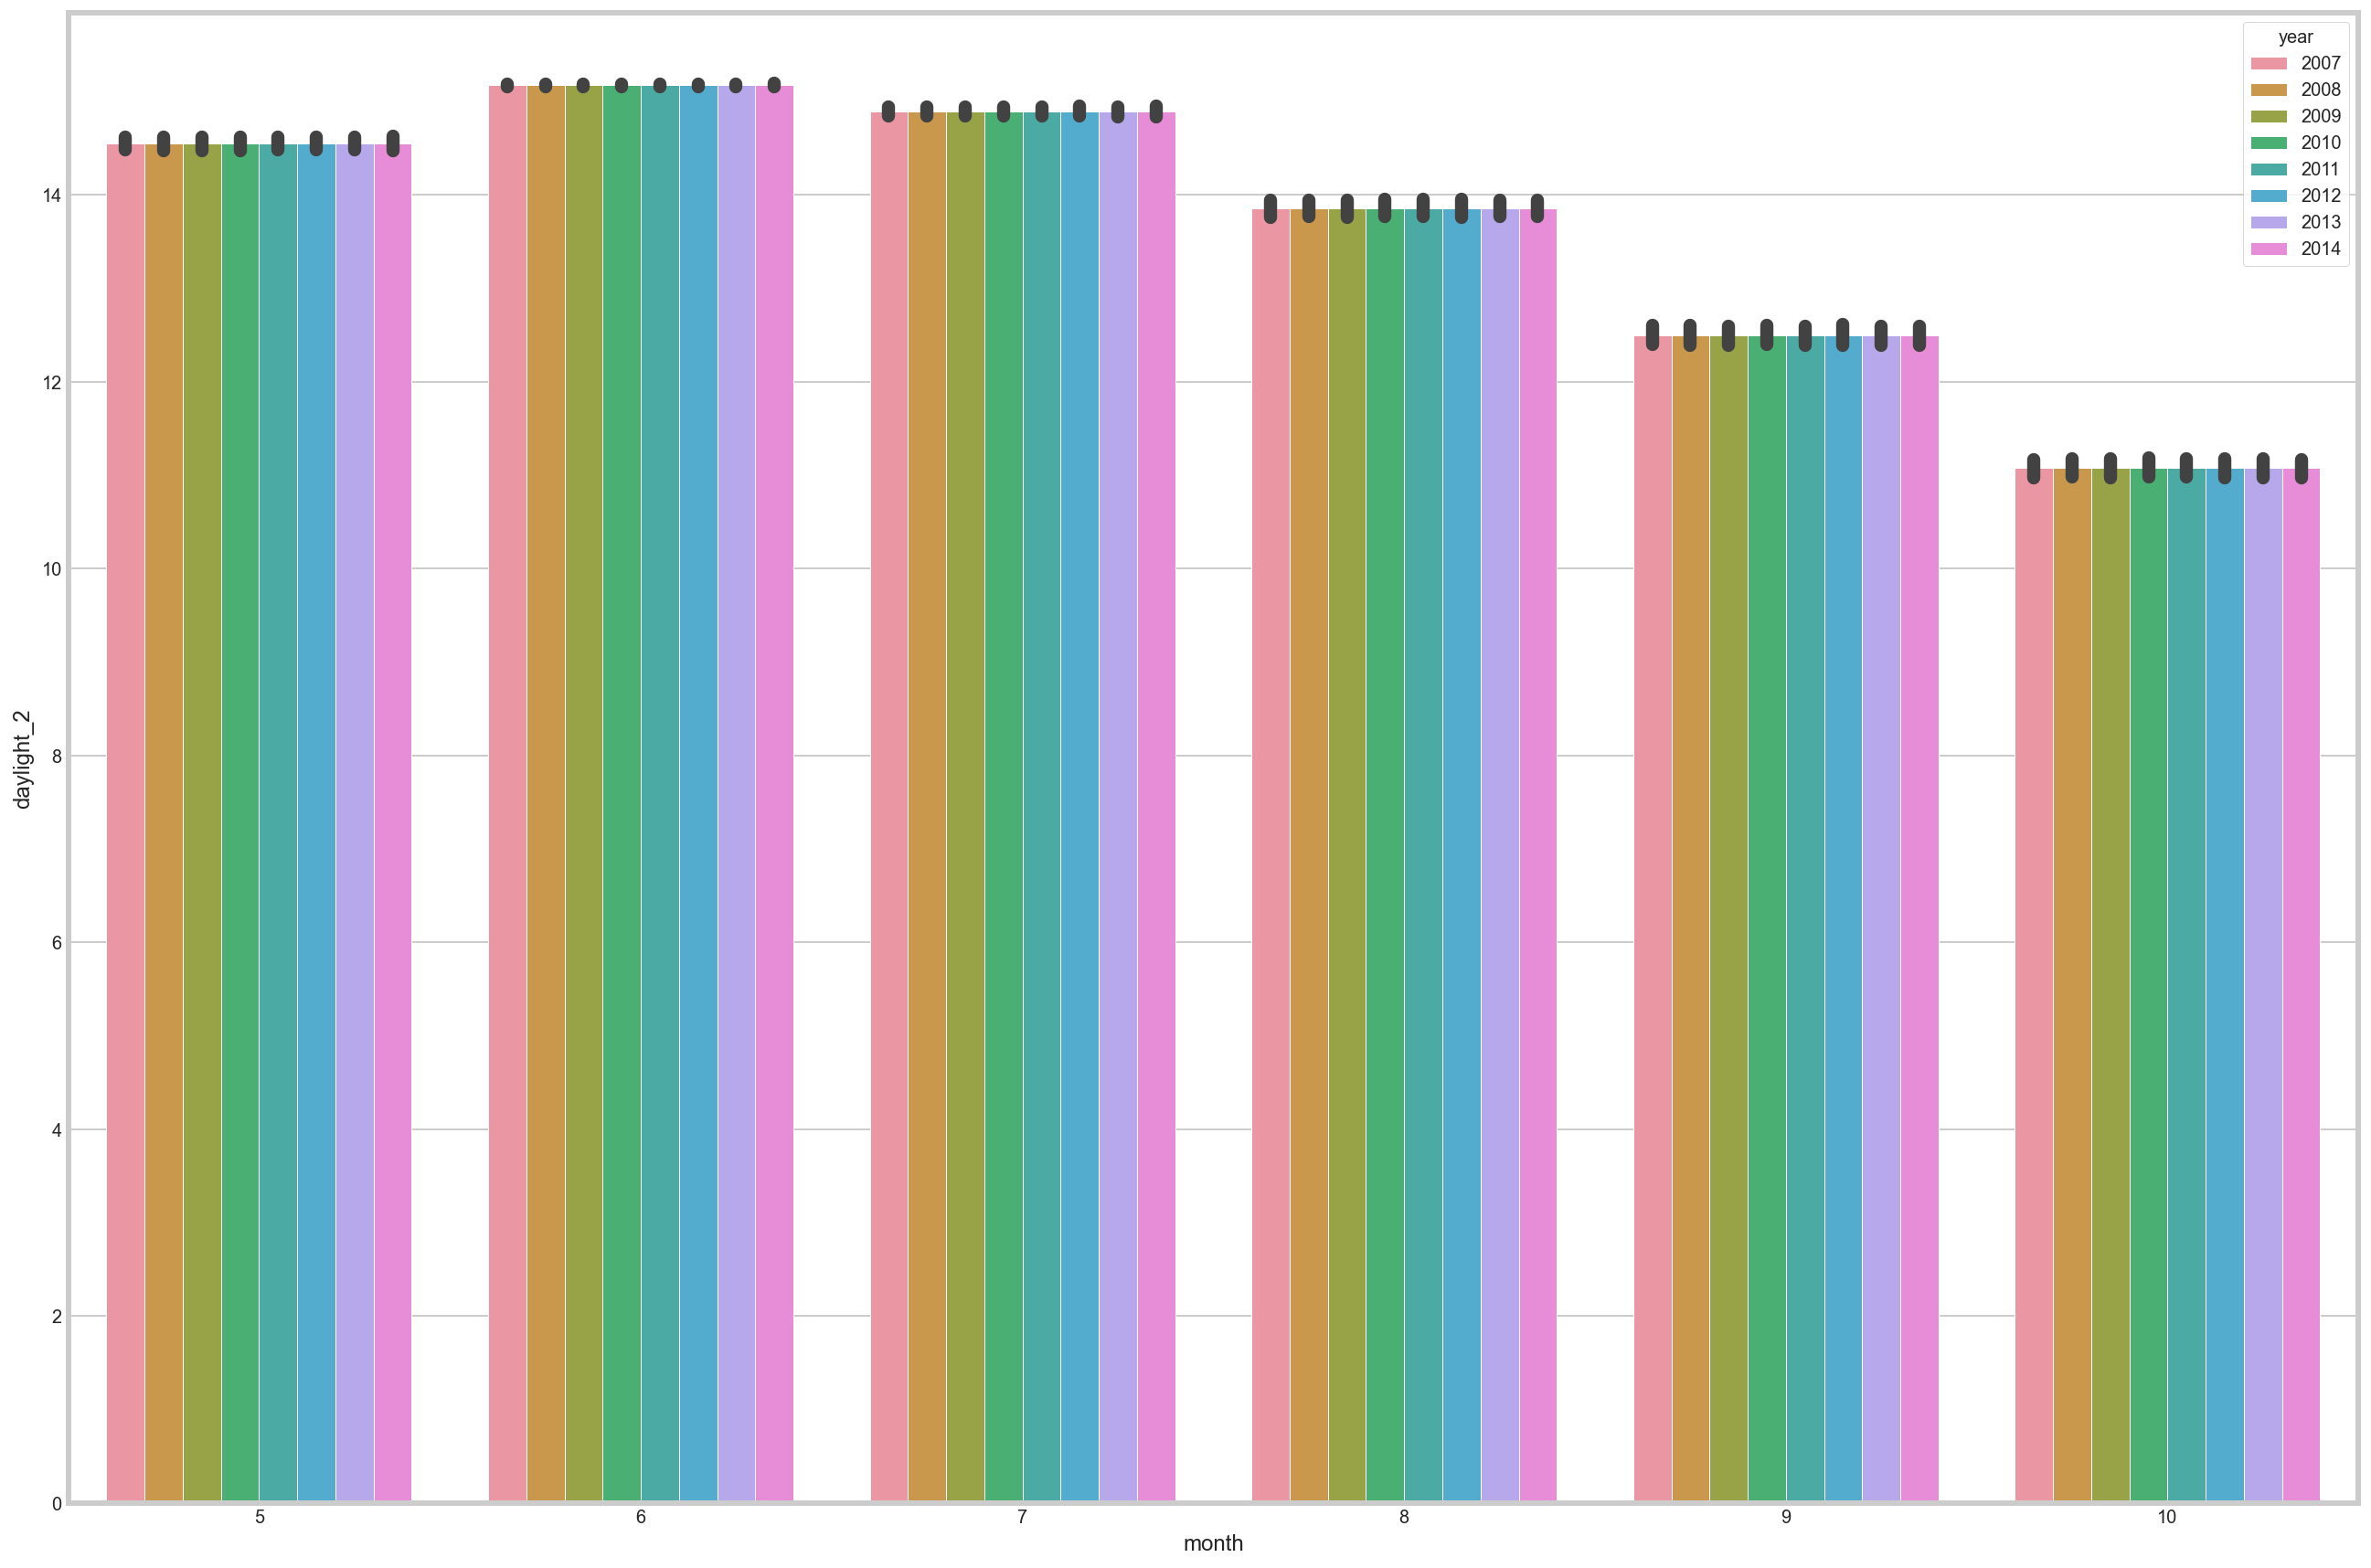

In [23]:
plt.figure(figsize=(20,15))

sns.barplot(data=df_weather,x='month',y='daylight_2',hue='year')

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


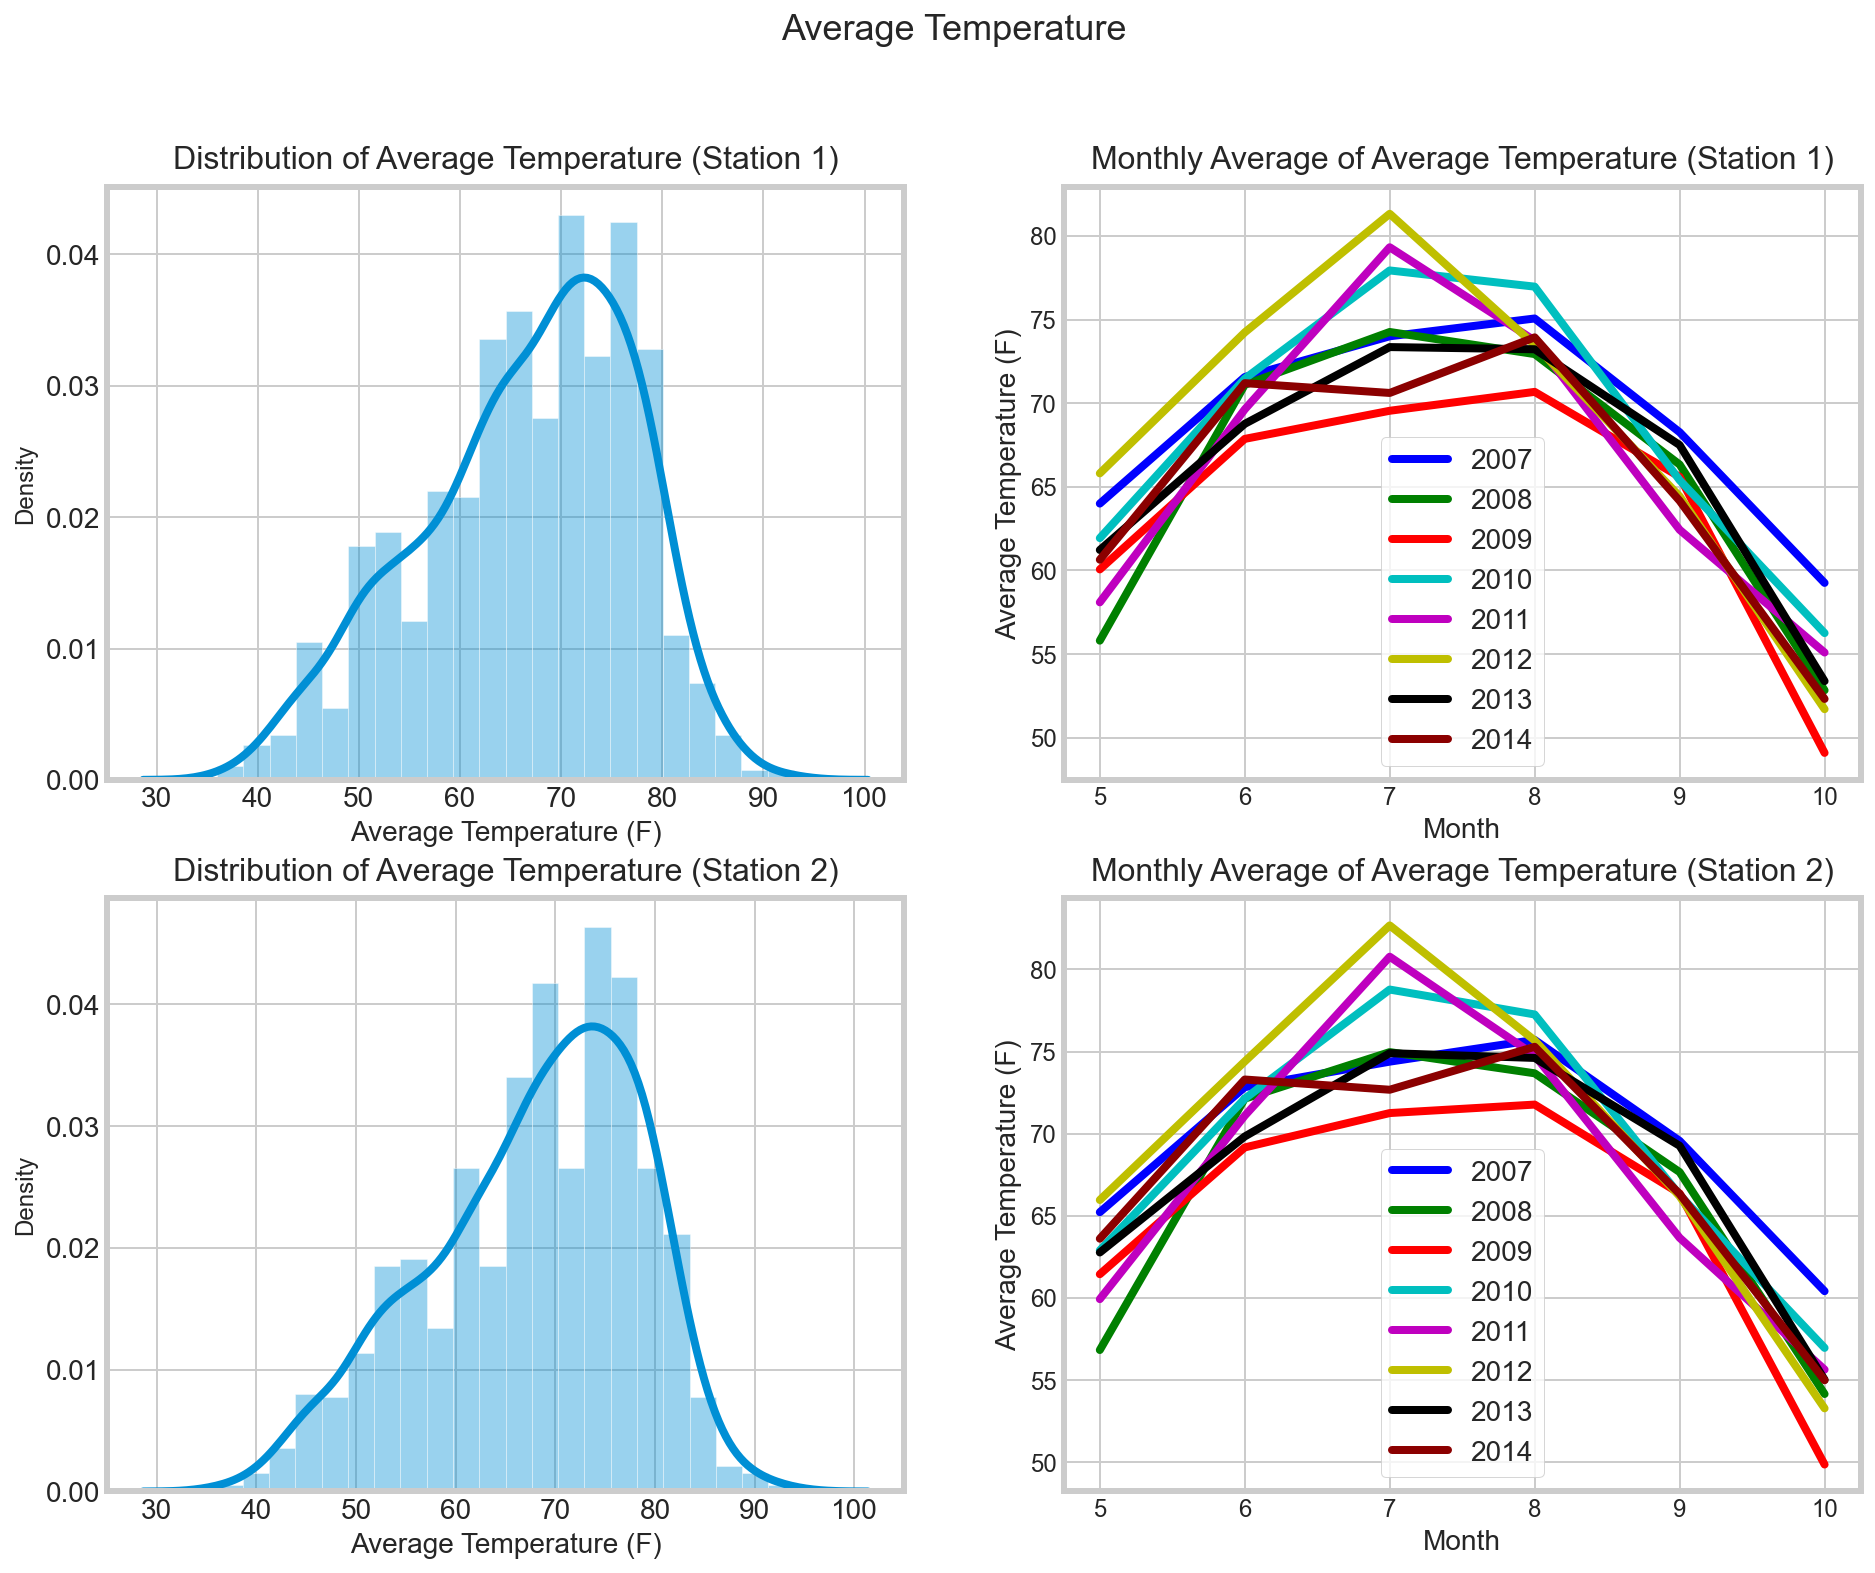

In [24]:
# Distribution of average temperature does not follow a normal distribution
# Average temperature peaks in Jul or Aug each year
# Similar distribution and trends observed for both stations

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
ax = ax.ravel()
plt.suptitle('Average Temperature', fontsize=18)

sns.distplot(df_weather[df_weather['station']==1].tavg, ax=ax[0])
df_weather[df_weather['station']==1].groupby(['month','year']).tavg.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

sns.distplot(df_weather[df_weather['station']==2].tavg, ax=ax[2])
df_weather[df_weather['station']==2].groupby(['month','year']).tavg.mean().unstack(fill_value=0).plot(
    ax=ax[3], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Average Temperature (Station 1)', fontsize=16, y=1.01)
ax[0].set_xlabel('Average Temperature (F)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average of Average Temperature (Station 1)', fontsize=16, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Temperature (F)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

ax[2].set_title('Distribution of Average Temperature (Station 2)', fontsize=16, y=1.01)
ax[2].set_xlabel('Average Temperature (F)', fontsize=14)
ax[2].tick_params(labelsize=14)

ax[3].set_title('Monthly Average of Average Temperature (Station 2)', fontsize=16, y=1.01)
ax[3].set_xlabel('Month', fontsize=14)
ax[3].set_ylabel('Average Temperature (F)', fontsize=14)
ax[3].tick_params(labelsize=12)
ax[3].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


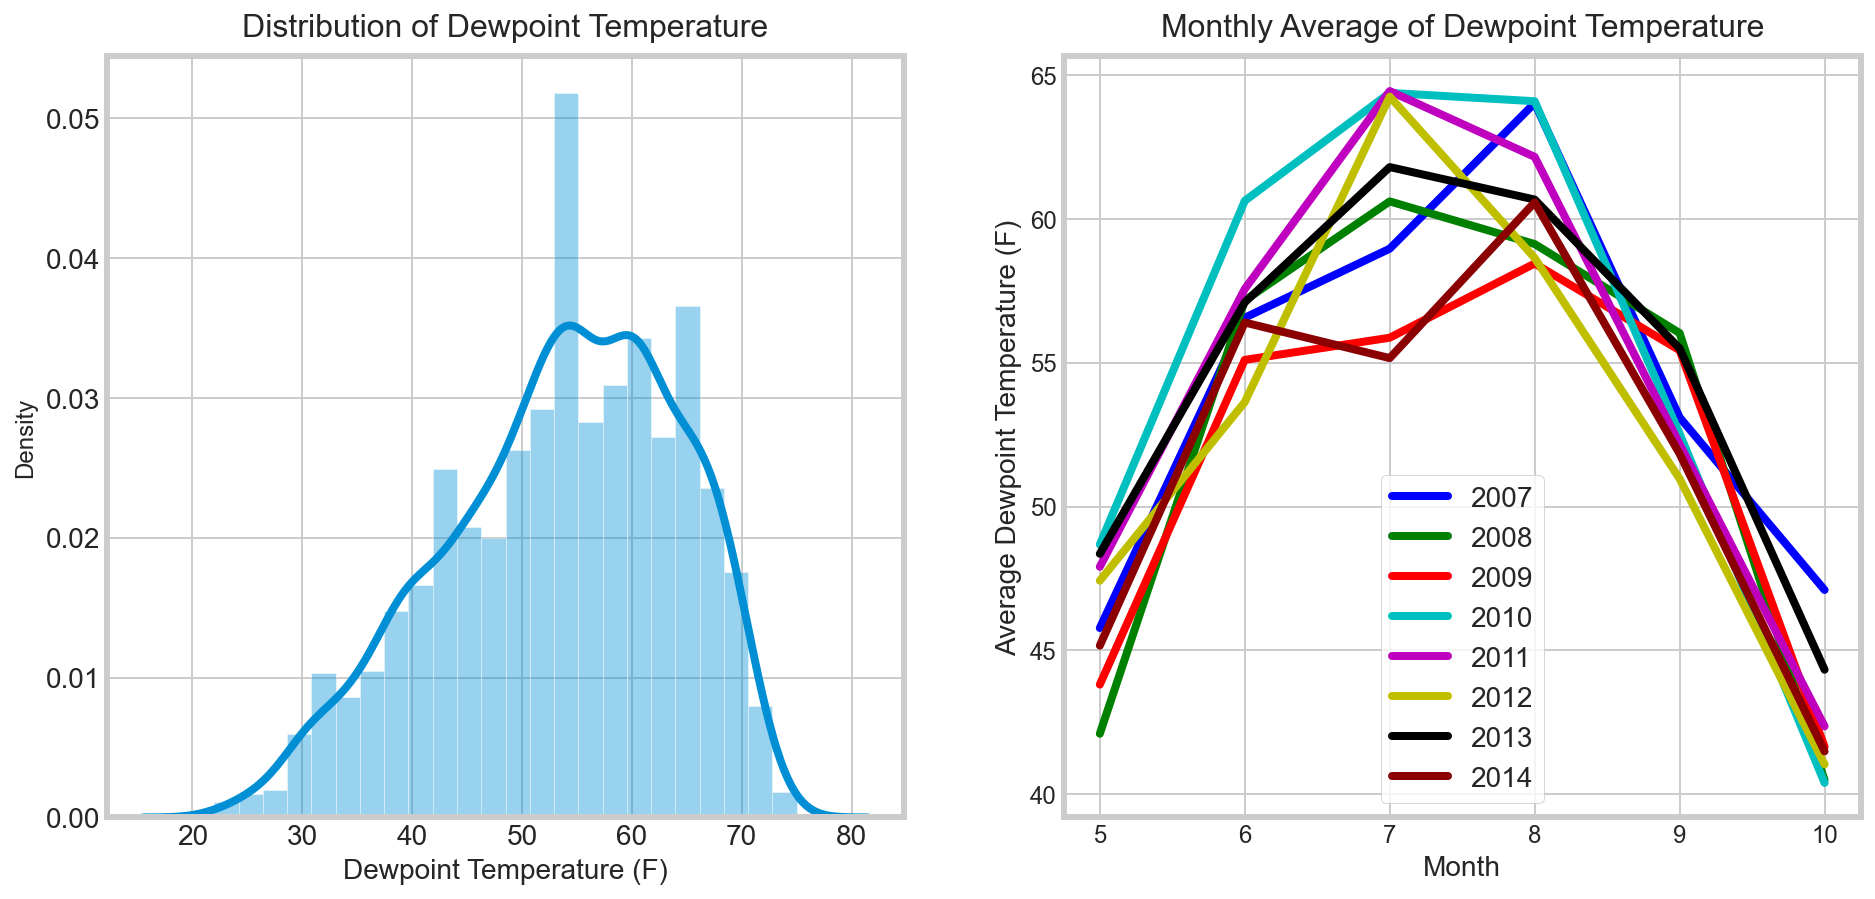

In [25]:
# Distribution of dewpoint temperature does not follow a normal distribution
# Dewpoint temperature peaks in Jul or Aug each year
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()

sns.distplot(df_weather.dewpoint, ax=ax[0])
df_weather[df_weather['station']==1].groupby(['month','year']).dewpoint.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Dewpoint Temperature', fontsize=16, y=1.01)
ax[0].set_xlabel('Dewpoint Temperature (F)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average of Dewpoint Temperature', fontsize=16, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Dewpoint Temperature (F)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


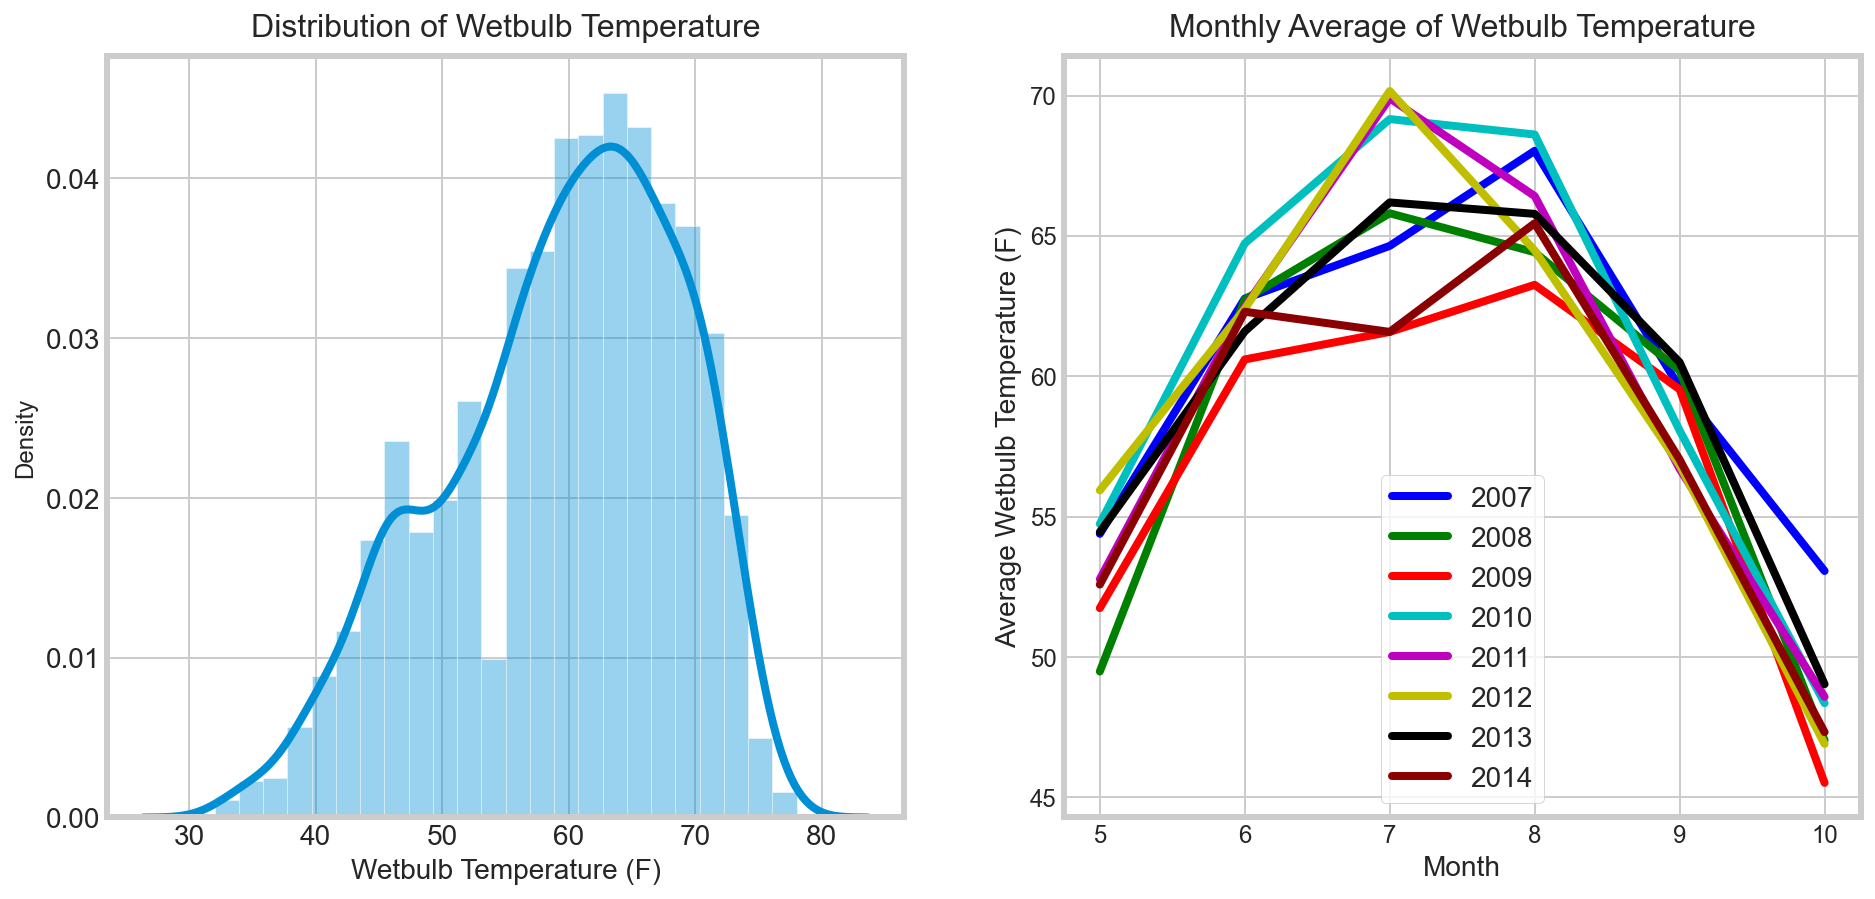

In [26]:
# Distribution of wetbulb temperature does not follow a normal distribution
# Wetbulb temperature peaks in Jul or Aug each year
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()

sns.distplot(df_weather.wetbulb, ax=ax[0])
df_weather[df_weather['station']==1].groupby(['month','year']).wetbulb.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Wetbulb Temperature', fontsize=16, y=1.01)
ax[0].set_xlabel('Wetbulb Temperature (F)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average of Wetbulb Temperature', fontsize=16, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Wetbulb Temperature (F)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


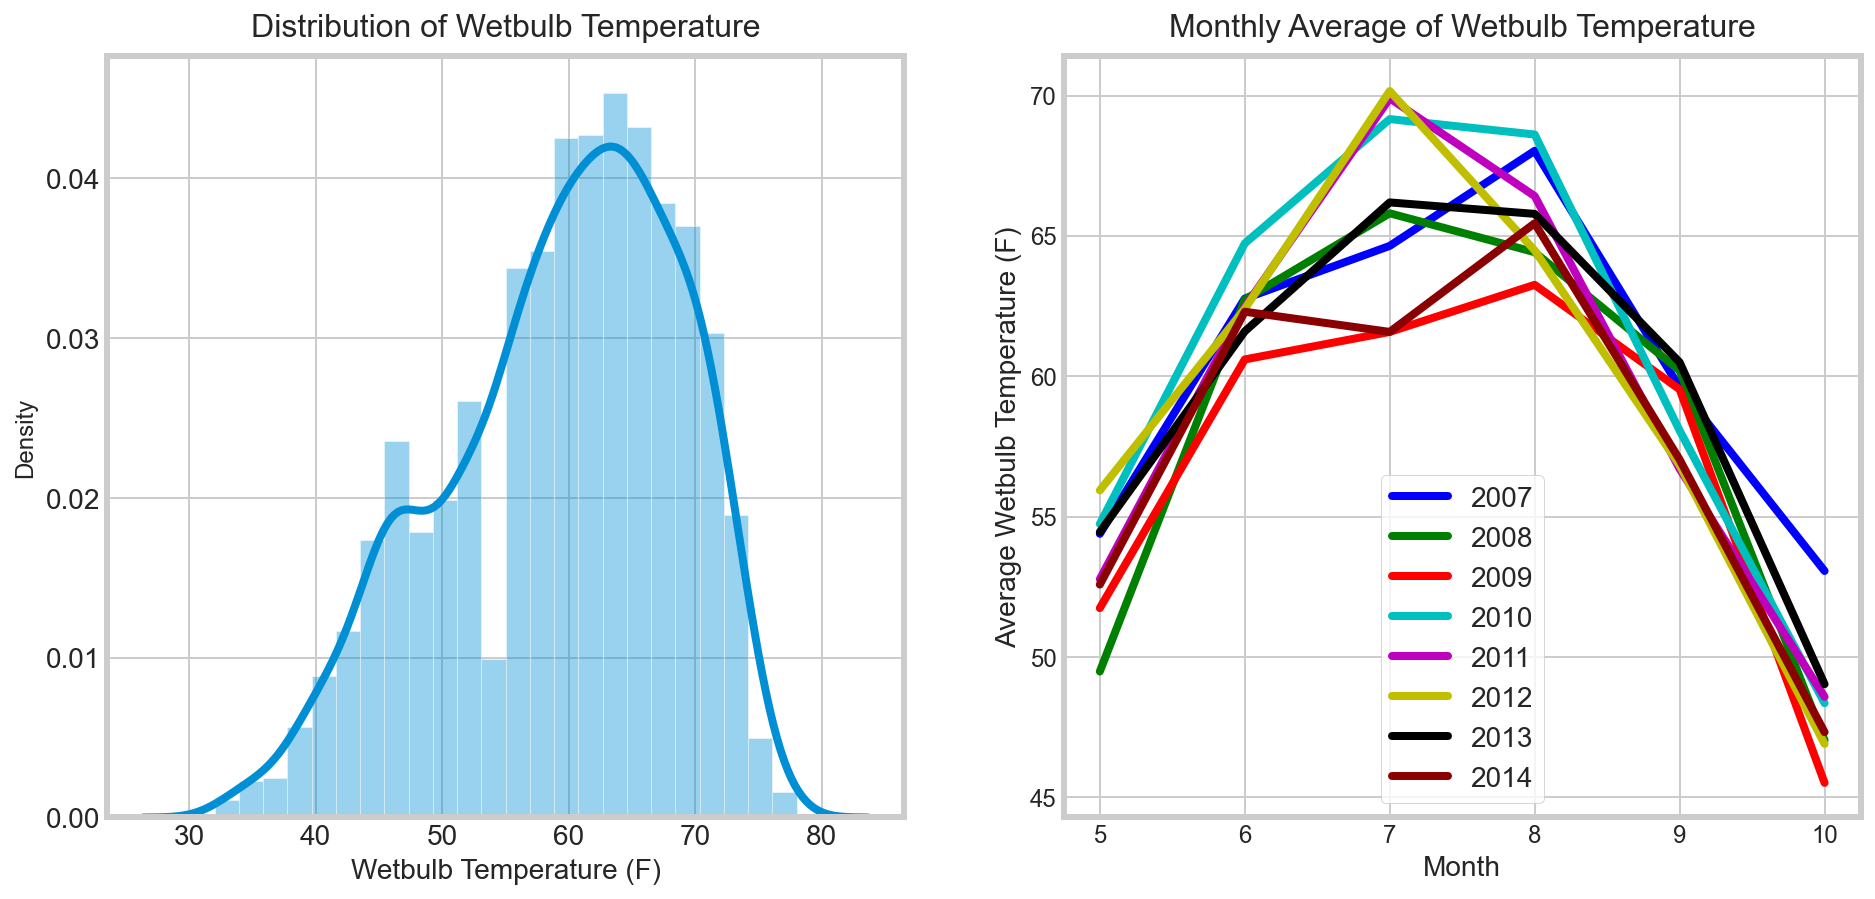

In [27]:
# Distribution of wetbulb temperature does not follow a normal distribution
# Wetbulb temperature peaks in Jul or Aug each year
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()

sns.distplot(df_weather.wetbulb, ax=ax[0])
df_weather[df_weather['station']==1].groupby(['month','year']).wetbulb.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Wetbulb Temperature', fontsize=16, y=1.01)
ax[0].set_xlabel('Wetbulb Temperature (F)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average of Wetbulb Temperature', fontsize=16, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Wetbulb Temperature (F)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


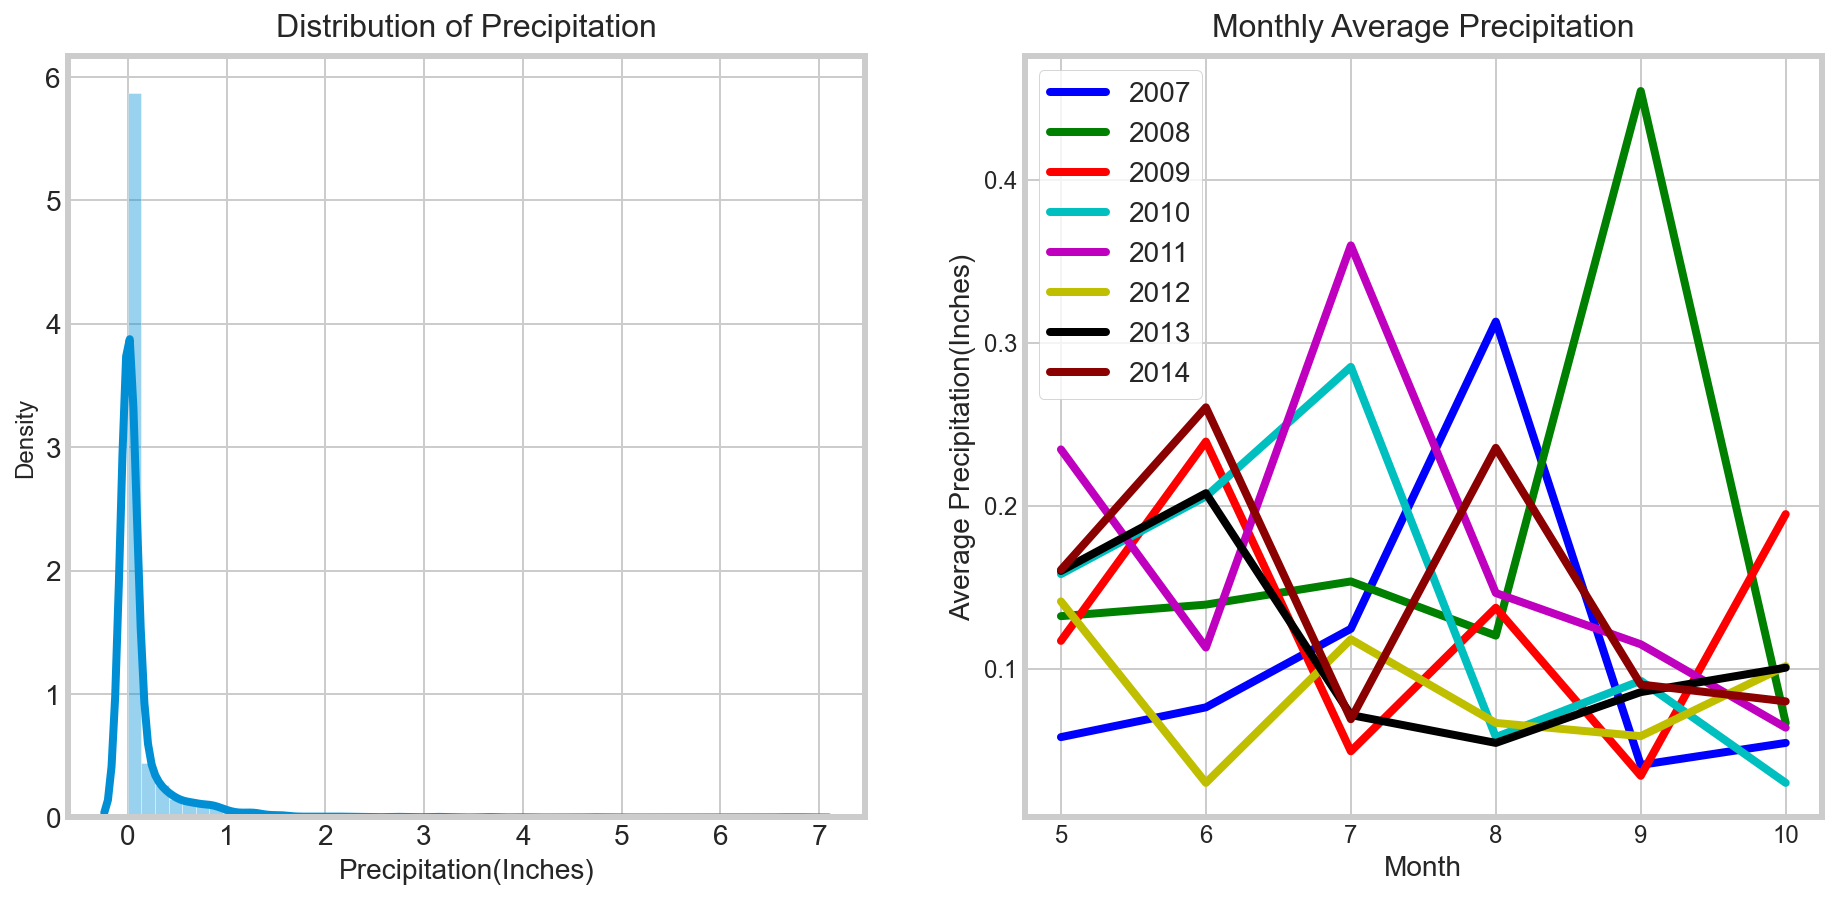

In [28]:
# Distribution of precipitation does not follow a normal distribution
# Monthly average precipitation does not show any trend throughout the years
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = ax.ravel()

sns.distplot(df_weather.preciptotal, ax=ax[0])
df_weather[df_weather['station']==1].groupby(['month','year']).preciptotal.mean().unstack(fill_value=0).plot(
    ax=ax[1], color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkred'])

ax[0].set_title('Distribution of Precipitation', fontsize=16, y=1.01)
ax[0].set_xlabel('Precipitation(Inches)', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].set_title('Monthly Average Precipitation', fontsize=16, y=1.01)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Average Precipitation(Inches)', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].legend(fontsize=14)

plt.subplots_adjust(wspace=0.2)

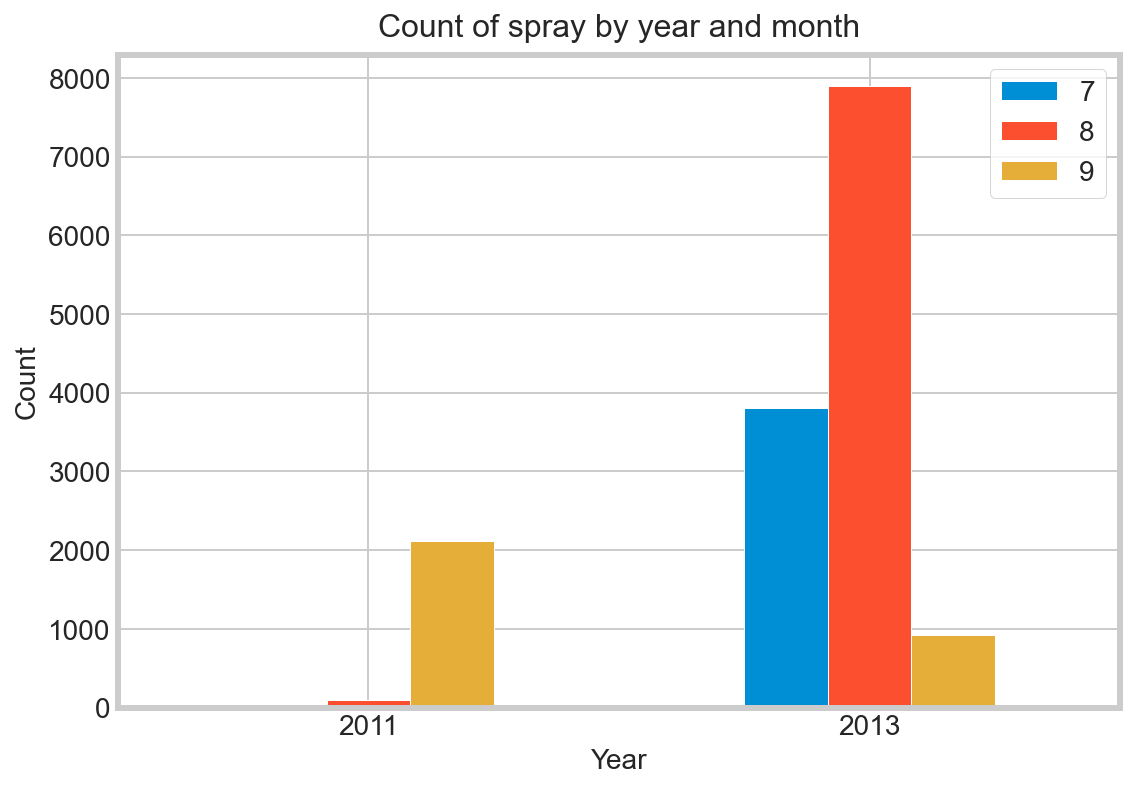

In [29]:
# Sprayed in Jul, Aug and Sep
df_spray.groupby(['year_spray', 'month_spray']).day_spray.count().unstack(fill_value=0).plot.bar(figsize=(8,6))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of spray by year and month', fontsize=16, y=1.01)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Visualization on Map

In [30]:
crs = {'init': 'epsg:4326'}

geometry_train = [Point(xy) for xy in zip(df_train['longitude'], df_train['latitude'])]

geo_df = gpd.GeoDataFrame(df_train,
                      crs=crs,
                      geometry=geometry_train)
geo_df.head()

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


species  block           street  trap   latitude  longitude  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002  41.954690 -87.800991   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002  41.954690 -87.800991   
2          CULEX RESTUANS     62    N MANDELL AVE  T007  41.994991 -87.769279   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015  41.974089 -87.824812   
4          CULEX RESTUANS     79     W FOSTER AVE  T015  41.974089 -87.824812   

   nummosquitos  wnvpresent  year  month  day                    geometry  
0             1           0  2007      5   29  POINT (-87.80099 41.95469)  
1             1           0  2007      5   29  POINT (-87.80099 41.95469)  
2             1           0  2007      5   29  POINT (-87.76928 41.99499)  
3             1           0  2007      5   29  POINT (-87.82481 41.97409)  
4             4           0  2007      5   29  POINT (-87.82481 41.97409)

In [31]:
geometry_spray = [Point(xy) for xy in zip(df_spray['longitude'], df_spray['latitude'])]

geo_spray_df = gpd.GeoDataFrame(df_spray,
                      crs=crs,
                      geometry=geometry_spray)
geo_spray_df.head()

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


latitude  longitude  year_spray  month_spray  day_spray  \
0  42.391623 -88.089163        2011            8         29   
1  42.391348 -88.089163        2011            8         29   
2  42.391022 -88.089157        2011            8         29   
3  42.390637 -88.089158        2011            8         29   
4  42.390410 -88.088858        2011            8         29   

                     geometry  
0  POINT (-88.08916 42.39162)  
1  POINT (-88.08916 42.39135)  
2  POINT (-88.08916 42.39102)  
3  POINT (-88.08916 42.39064)  
4  POINT (-88.08886 42.39041)

In [32]:
#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

df_station = pd.DataFrame({
    'station': ["O'HARE INTERNATIONAL AIRPORT", "MIDWAY INTL ARPT"],
    'latitude': [41.995, 41.786],
    'longitude': [-87.933, -87.752]
})

geometry_station = [Point(xy) for xy in zip(df_station['longitude'], df_station['latitude'])]

geo_station_df = gpd.GeoDataFrame(df_station,
                      crs=crs,
                      geometry=geometry_station)
geo_station_df.head()

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


station  latitude  longitude  \
0  O'HARE INTERNATIONAL AIRPORT    41.995    -87.933   
1              MIDWAY INTL ARPT    41.786    -87.752   

                     geometry  
0  POINT (-87.93300 41.99500)  
1  POINT (-87.75200 41.78600)

The map below shows the areas where CDC chose to spray and spots where the traps are located. It is unclear from the map below CDC's rationale behind their decision to spray those areas.

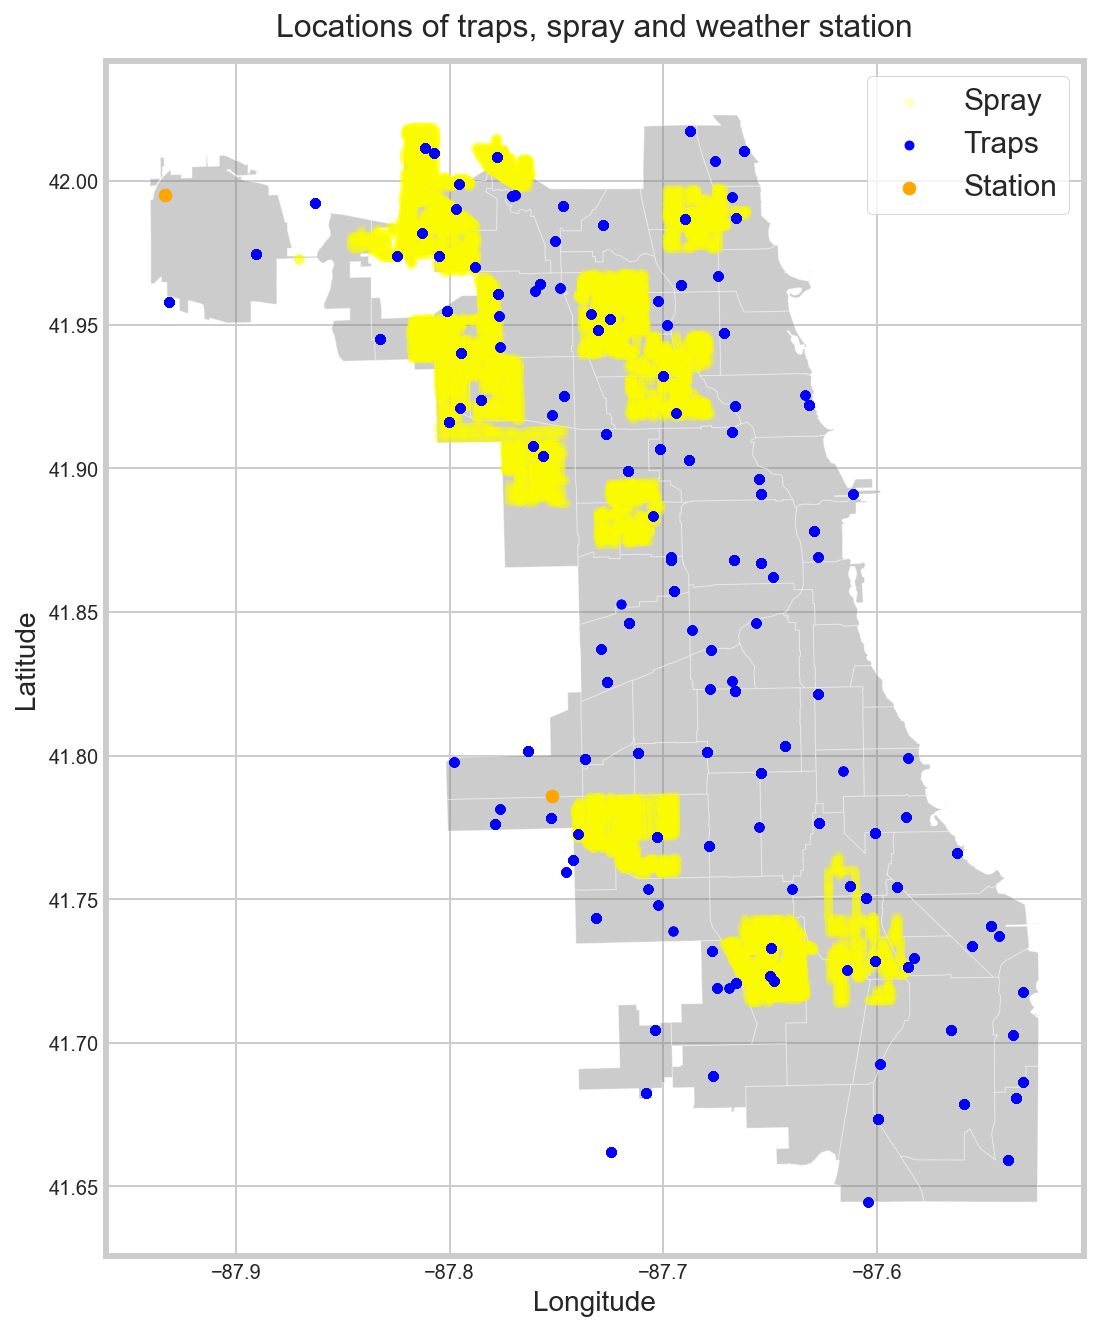

In [33]:
# Plot location of traps, spray and weather station
# There were spray locations outside Chicago and were filtered out from the plot

fig, ax = plt.subplots(figsize=(11,11))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_spray_df[geo_spray_df['latitude']<42.3].plot(
    ax=ax, markersize=20, color='yellow', marker='o', alpha=0.2, label='Spray')
geo_df.plot(ax=ax, markersize=20, color='blue', marker='o', label='Traps')
geo_station_df.plot(ax=ax, markersize=40, color='orange', marker='o', label='Station')
plt.legend(prop={'size': 15})
plt.title('Locations of traps, spray and weather station', fontsize=16, y=1.01)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


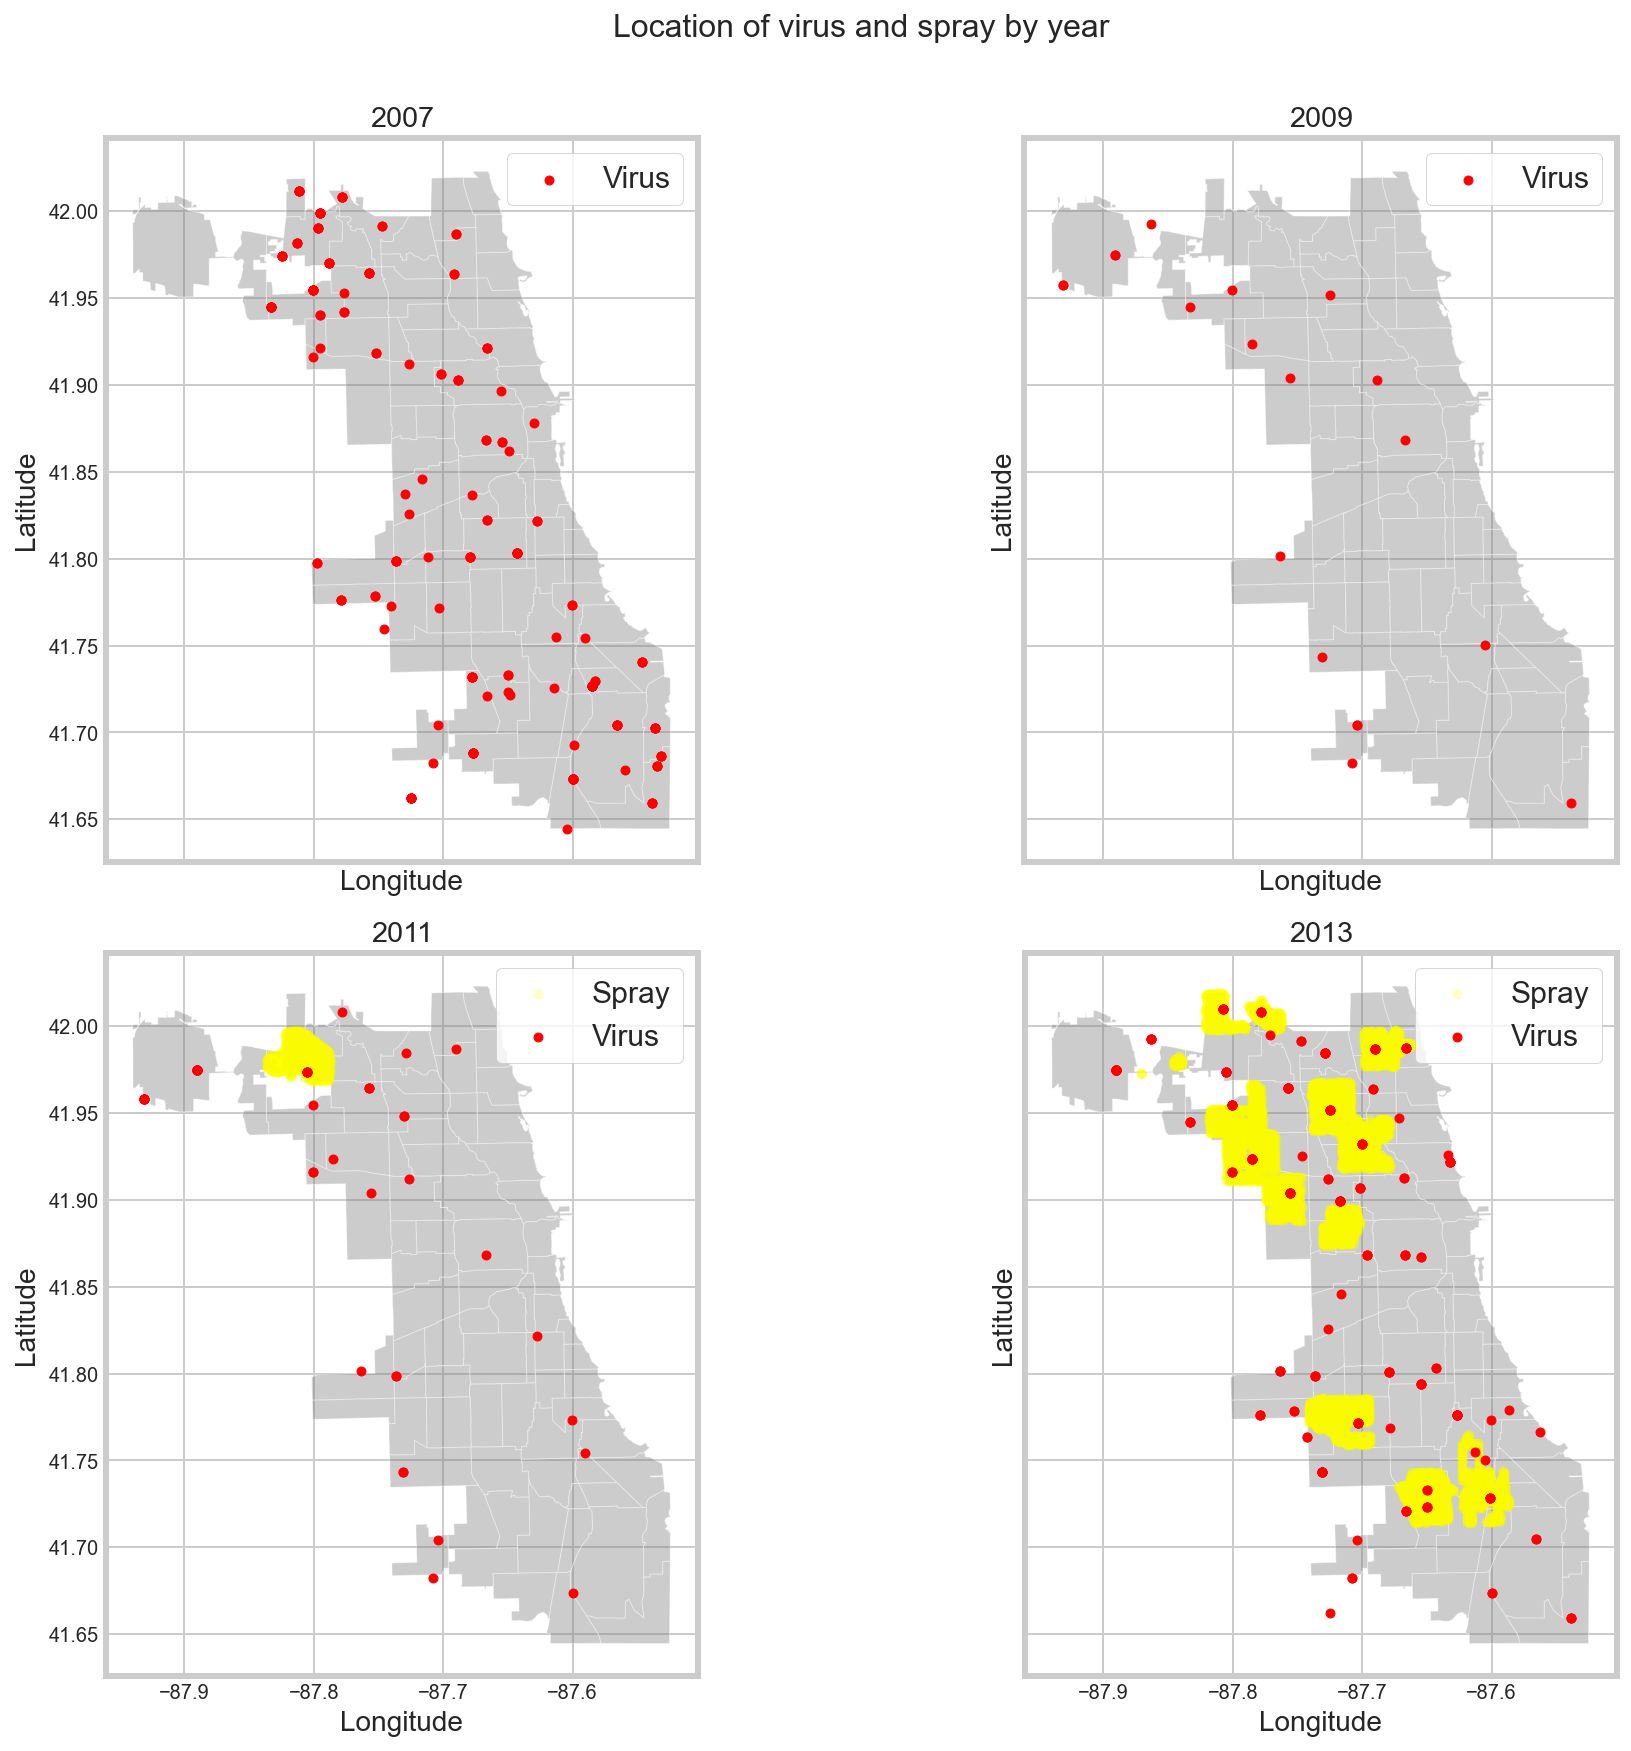

In [34]:
# all years
# Presence of virus still observed at locations sprayed - spray was not effective/ time sprayed was not correct?

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)
ax = ax.ravel()
plt.suptitle('Location of virus and spray by year', fontsize=16, y=1.01)

mask_remove_outliers = geo_spray_df['latitude'] < 42.3
mask_wnvpresent = geo_df['wnvpresent'] == 1

for i, y in enumerate(df_train.year.unique()):
    
    mask_year = geo_spray_df['year_spray'] == y
    mask_year_2 = geo_df['year'] == y
    
    street_map.plot(ax=ax[i], alpha=0.4, color='grey')
    
    geo_spray_df[mask_remove_outliers & mask_year].plot(ax=ax[i], markersize=20, color='yellow', marker='o', alpha=0.2, label='Spray')
    geo_df[mask_wnvpresent & mask_year_2].plot(ax=ax[i], markersize=20, color='red', marker='o', label='Virus')
    
    ax[i].legend(prop={'size': 15})
    ax[i].set_title(y)
    ax[i].set_xlabel('Longitude', fontsize=14)
    ax[i].set_ylabel('Latitude', fontsize=14)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

As shown above, spraying were only performed in 2011 and 2013. In addition, the spray area did not cover most of the WNV clusters.

In [35]:
# # year 2011
# # Presence of virus still observed at locations sprayed - spray was not effective/ time sprayed was not correct?

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)
# ax = ax.ravel()
# plt.suptitle('Year 2011: Location of virus and spray by month', fontsize=16, y=1.01)

# mask_remove_outliers = geo_spray_df['latitude'] < 42.3
# mask_wnvpresent = geo_df['wnvpresent'] == 1

# year = 2011
# mask_year = df_train['year'] == year
# mask_year_2 = geo_spray_df['year_spray'] == year
# mask_year_3 = geo_df['year'] == year

# for i, y in enumerate(df_train[mask_year].month.unique()):
    
#     mask_month = geo_spray_df['month_spray'] == y
#     mask_month_2 = geo_df['month'] == y   
    
#     street_map.plot(ax=ax[i], alpha=0.4, color='grey')
    
#     geo_spray_df[mask_remove_outliers & mask_month & mask_year_2].plot(ax=ax[i], markersize=20, color='yellow', marker='o', alpha=0.2, label='Spray')
#     geo_df[mask_wnvpresent & mask_month_2 & mask_year_3].plot(ax=ax[i], markersize=20, color='red', marker='o', label='Virus')
       
#     ax[i].legend(prop={'size': 15})
#     ax[i].set_title(y)
#     ax[i].set_xlabel('Longitude', fontsize=14)
#     ax[i].set_ylabel('Latitude', fontsize=14)
    
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.2)

/Users/bbobpcr/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


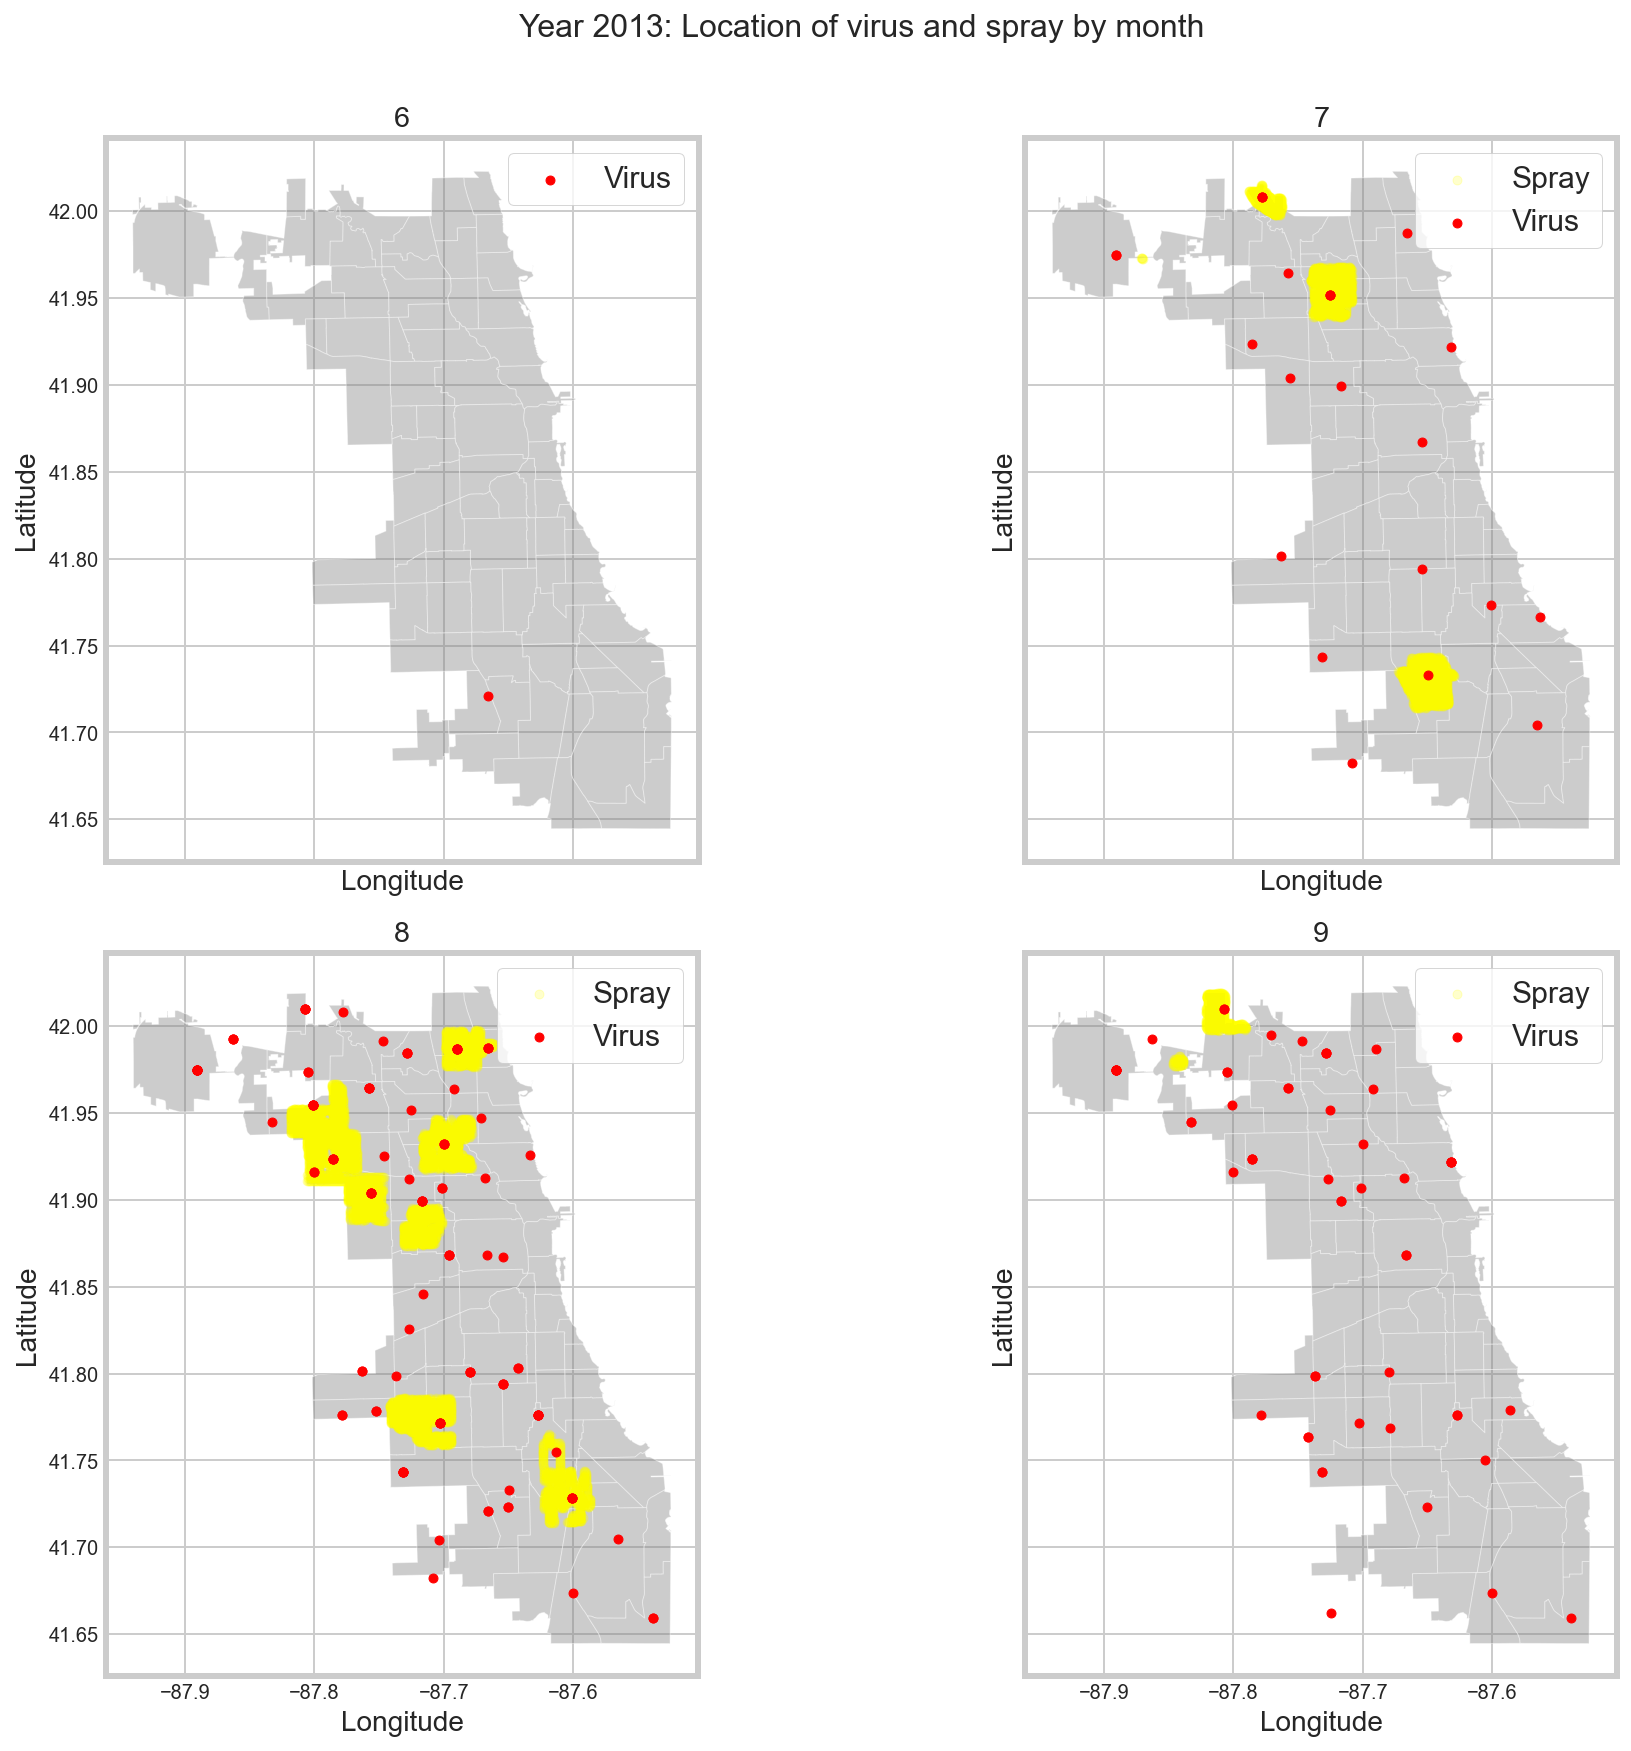

In [36]:
# year 2013
# Presence of virus still observed at locations sprayed - spray was not effective/ time sprayed was not correct?

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)
ax = ax.ravel()
plt.suptitle('Year 2013: Location of virus and spray by month', fontsize=16, y=1.01)

mask_remove_outliers = geo_spray_df['latitude'] < 42.3
mask_wnvpresent = geo_df['wnvpresent'] == 1

year = 2013
mask_year = df_train['year'] == year
mask_year_2 = geo_spray_df['year_spray'] == year
mask_year_3 = geo_df['year'] == year

for i, y in enumerate(df_train[mask_year].month.unique()):
    
    mask_month = geo_spray_df['month_spray'] == y
    mask_month_2 = geo_df['month'] == y   
    
    street_map.plot(ax=ax[i], alpha=0.4, color='grey')
    
    geo_spray_df[mask_remove_outliers & mask_month & mask_year_2].plot(ax=ax[i], markersize=20, color='yellow', marker='o', alpha=0.2, label='Spray')
    geo_df[mask_wnvpresent & mask_month_2 & mask_year_3].plot(ax=ax[i], markersize=20, color='red', marker='o', label='Virus')
       
    ax[i].legend(prop={'size': 15})
    ax[i].set_title(y)
    ax[i].set_xlabel('Longitude', fontsize=14)
    ax[i].set_ylabel('Latitude', fontsize=14)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)



As shown above, the first WNV virus was detected in June and spraying was conducted by the next month in July. Spraying efforts were expanded to more areas in August but the virus continued to spread to most areas in the next 2 months.

In [37]:
only_station_1 = df_weather[df_weather['station'] == 1] 
combined = df_train.merge(only_station_1, how='left', on=['year','month','day'])

In [38]:
combined.head()

species  block           street  trap   latitude  longitude  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002  41.954690 -87.800991   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002  41.954690 -87.800991   
2          CULEX RESTUANS     62    N MANDELL AVE  T007  41.994991 -87.769279   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015  41.974089 -87.824812   
4          CULEX RESTUANS     79     W FOSTER AVE  T015  41.974089 -87.824812   

   nummosquitos  wnvpresent  year  month  ...  preciptotal stnpressure  \
0             1           0  2007      5  ...          0.0       29.39   
1             1           0  2007      5  ...          0.0       29.39   
2             1           0  2007      5  ...          0.0       29.39   
3             1           0  2007      5  ...          0.0       29.39   
4             4           0  2007      5  ...          0.0       29.39   

   sealevel  resultspeed  resultdir  avgspeed           sunrise_2  \
0     30.11          5.8         18       6.5 1900-01-01 04:21:00   
1     30.11          5.8         18       6.5 1900-01-01 04:21:00   
2     30.11          5.8         18       6.5 1900-01-01 04:21:00   
3     30.11          5.8         18       6.5 1900-01-01 04:21:00   
4     30.11          5.8         18       6.5 1900-01-01 04:21:00   

             sunset_2        daylight  daylight_2  
0 1900-01-01 19:17:00 0 days 14:56:00   14.933333  
1 1900-01-01 19:17:00 0 days 14:56:00   14.933333  
2 1900-01-01 19:17:00 0 days 14:56:00   14.933333  
3 1900-01-01 19:17:00 0 days 14:56:00   14.933333  
4 1900-01-01 19:17:00 0 days 14:56:00   14.933333  

[5 rows x 33 columns]

<AxesSubplot:>

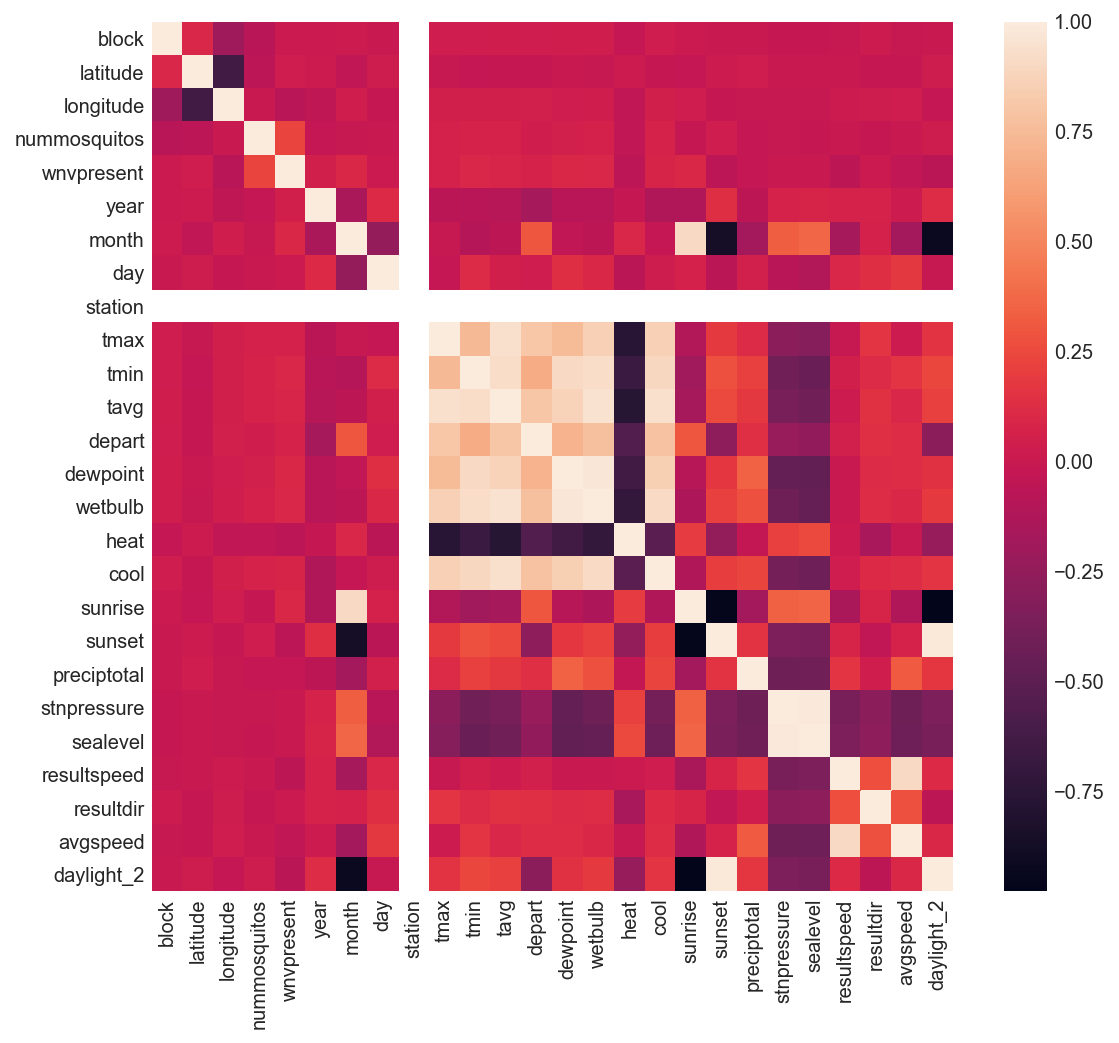

In [39]:
plt.figure(figsize=(8,8))
sns.heatmap(combined.corr())

In [40]:
def combined_date(row):
    date = '{}-{}-{}'.format(row.year, row.month, row.day)
    return datetime.datetime.strptime(date, '%Y-%m-%d')

In [41]:
df_train['date'] = df_train.apply(combined_date, axis=1)
df_train.head()

species  block           street  trap   latitude  longitude  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002  41.954690 -87.800991   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002  41.954690 -87.800991   
2          CULEX RESTUANS     62    N MANDELL AVE  T007  41.994991 -87.769279   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015  41.974089 -87.824812   
4          CULEX RESTUANS     79     W FOSTER AVE  T015  41.974089 -87.824812   

   nummosquitos  wnvpresent  year  month  day                    geometry  \
0             1           0  2007      5   29  POINT (-87.80099 41.95469)   
1             1           0  2007      5   29  POINT (-87.80099 41.95469)   
2             1           0  2007      5   29  POINT (-87.76928 41.99499)   
3             1           0  2007      5   29  POINT (-87.82481 41.97409)   
4             4           0  2007      5   29  POINT (-87.82481 41.97409)   

        date  
0 2007-05-29  
1 2007-05-29  
2 2007-05-29  
3 2007-05-29  
4 2007-05-29

In [42]:
df_weather['date'] = df_weather.apply(combined_date, axis=1)
df_weather.head()

station  tmax  tmin  tavg  depart  dewpoint  wetbulb  heat  cool  sunrise  \
0        1    83    50    67      14        51     56.0     0     2      448   
1        2    84    52    68      14        51     57.0     0     3      448   
2        1    59    42    51      -3        42     47.0    14     0      447   
3        2    60    43    52      -3        42     47.0    13     0      447   
4        1    66    46    56       2        40     48.0     9     0      446   

   ...  resultdir  avgspeed  year  month  day           sunrise_2  \
0  ...         27       9.2  2007      5    1 1900-01-01 04:48:00   
1  ...         25       9.6  2007      5    1 1900-01-01 04:48:00   
2  ...          4      13.4  2007      5    2 1900-01-01 04:47:00   
3  ...          2      13.4  2007      5    2 1900-01-01 04:47:00   
4  ...          7      11.9  2007      5    3 1900-01-01 04:46:00   

             sunset_2        daylight  daylight_2       date  
0 1900-01-01 18:49:00 0 days 14:01:00   14.016667 2007-05-01  
1 1900-01-01 18:49:00 0 days 14:01:00   14.016667 2007-05-01  
2 1900-01-01 18:50:00 0 days 14:03:00   14.050000 2007-05-02  
3 1900-01-01 18:50:00 0 days 14:03:00   14.050000 2007-05-02  
4 1900-01-01 18:51:00 0 days 14:05:00   14.083333 2007-05-03  

[5 rows x 25 columns]

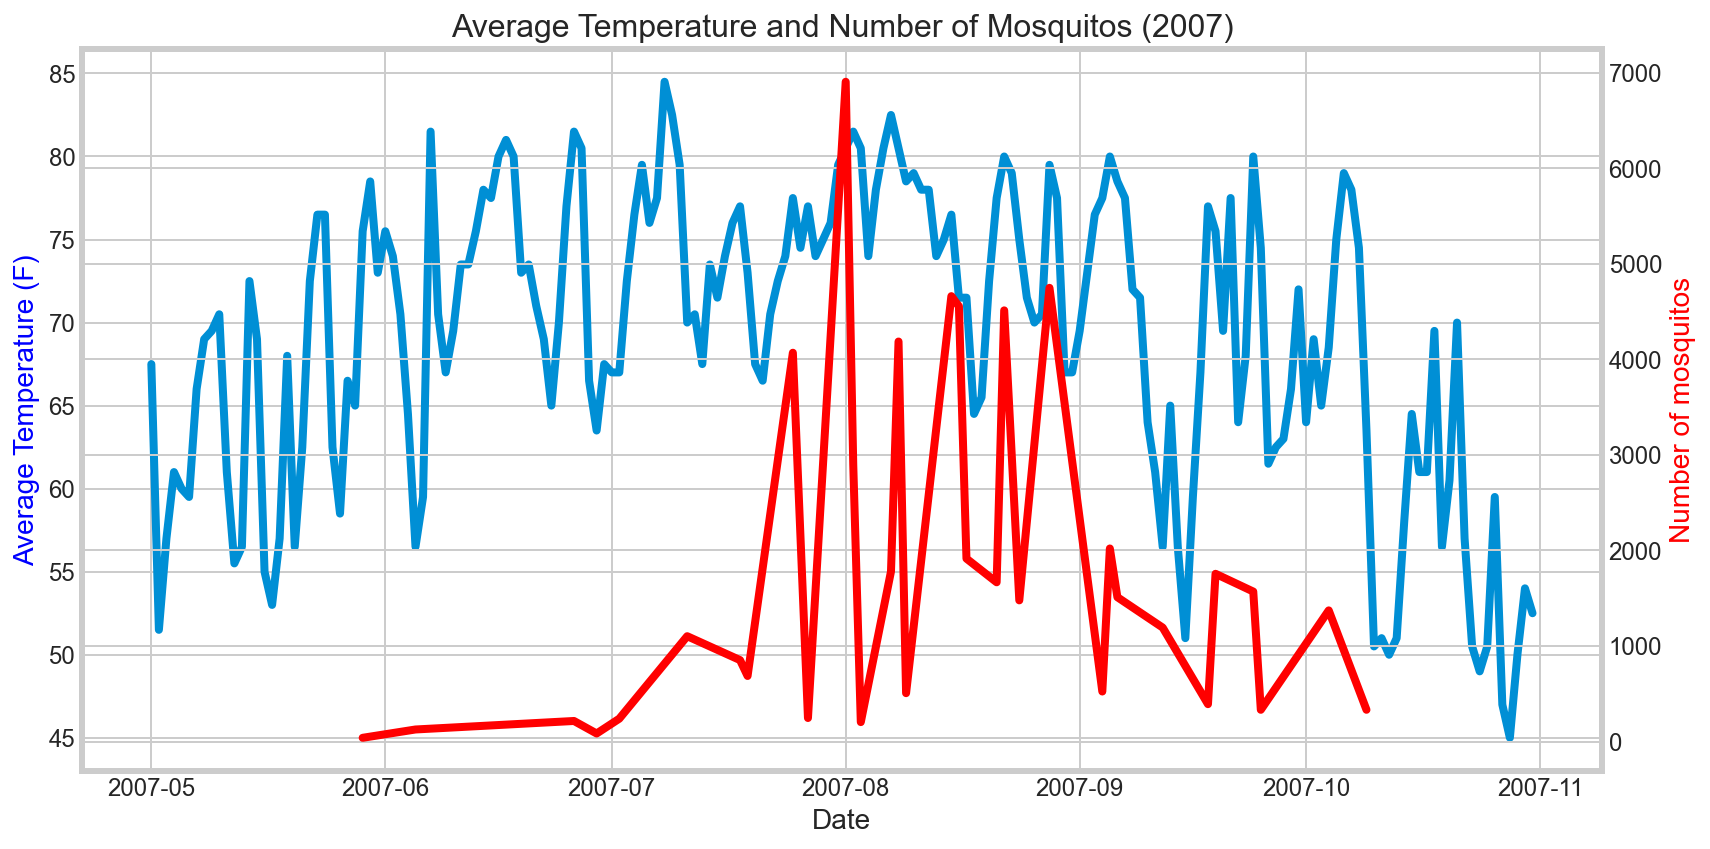

In [43]:
fig, ax1 = plt.subplots(figsize=(12,6))

mask_year = df_weather['year'] == 2007

sns.lineplot(x=df_weather[df_weather['year'] == 2007].date, y=df_weather[df_weather['year'] == 2007].tavg, ci=None, ax=ax1)
ax1.set_ylabel('Average Temperature (F)', color='blue', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.tick_params(labelsize=12)

mosquito_day = df_train[df_train['year'] == 2007].groupby(['date']).nummosquitos.sum()
df_mosquito_day = pd.DataFrame(mosquito_day)

ax2 = ax1.twinx()
sns.lineplot(x=df_mosquito_day.index, y=df_mosquito_day.nummosquitos, 
             ci=None, ax=ax2, color='r')
ax2.set_ylabel('Number of mosquitos', color='r', fontsize=14)
ax2.tick_params(labelsize=12)

plt.title('Average Temperature and Number of Mosquitos (2007)', fontsize=16)
fig.tight_layout()
plt.show()

In [44]:
df_weather[df_weather['year'] == 2009]

station  tmax  tmin  tavg  depart  dewpoint  wetbulb  heat  cool  \
736         1    60    46    53       0        40     47.0    12     0   
737         2    62    48    55       0        42     48.0    10     0   
738         1    66    44    55       1        33     45.0    10     0   
739         2    65    45    55       1        34     46.0    10     0   
740         1    70    43    57       3        34     47.0     8     0   
...       ...   ...   ...   ...     ...       ...      ...   ...   ...   
1099        2    60    48    54       7        50     52.0    11     0   
1100        1    67    46    57      11        53     56.0     8     0   
1101        2    68    47    58      11        54     56.0     7     0   
1102        1    46    35    41      -5        31     38.0    24     0   
1103        2    47    37    42      -5        31     38.0    23     0   

      sunrise  ...  resultdir  avgspeed  year  month  day           sunrise_2  \
736       448  ...         29       8.5  2009      5    1 1900-01-01 04:48:00   
737       448  ...         29       8.6  2009      5    1 1900-01-01 04:48:00   
738       447  ...         26       9.2  2009      5    2 1900-01-01 04:47:00   
739       447  ...         27       9.5  2009      5    2 1900-01-01 04:47:00   
740       446  ...         26       4.9  2009      5    3 1900-01-01 04:46:00   
...       ...  ...        ...       ...   ...    ...  ...                 ...   
1099      620  ...         14      11.4  2009     10   29 1900-01-01 06:20:00   
1100      622  ...         20      17.4  2009     10   30 1900-01-01 06:22:00   
1101      622  ...         21      17.9  2009     10   30 1900-01-01 06:22:00   
1102      623  ...         26      11.5  2009     10   31 1900-01-01 06:23:00   
1103      623  ...         26      13.8  2009     10   31 1900-01-01 06:23:00   

                sunset_2        daylight  daylight_2       date  
736  1900-01-01 18:49:00 0 days 14:01:00   14.016667 2009-05-01  
737  1900-01-01 18:49:00 0 days 14:01:00   14.016667 2009-05-01  
738  1900-01-01 18:50:00 0 days 14:03:00   14.050000 2009-05-02  
739  1900-01-01 18:50:00 0 days 14:03:00   14.050000 2009-05-02  
740  1900-01-01 18:51:00 0 days 14:05:00   14.083333 2009-05-03  
...                  ...             ...         ...        ...  
1099 1900-01-01 16:50:00 0 days 10:30:00   10.500000 2009-10-29  
1100 1900-01-01 16:49:00 0 days 10:27:00   10.450000 2009-10-30  
1101 1900-01-01 16:49:00 0 days 10:27:00   10.450000 2009-10-30  
1102 1900-01-01 16:47:00 0 days 10:24:00   10.400000 2009-10-31  
1103 1900-01-01 16:47:00 0 days 10:24:00   10.400000 2009-10-31  

[368 rows x 25 columns]

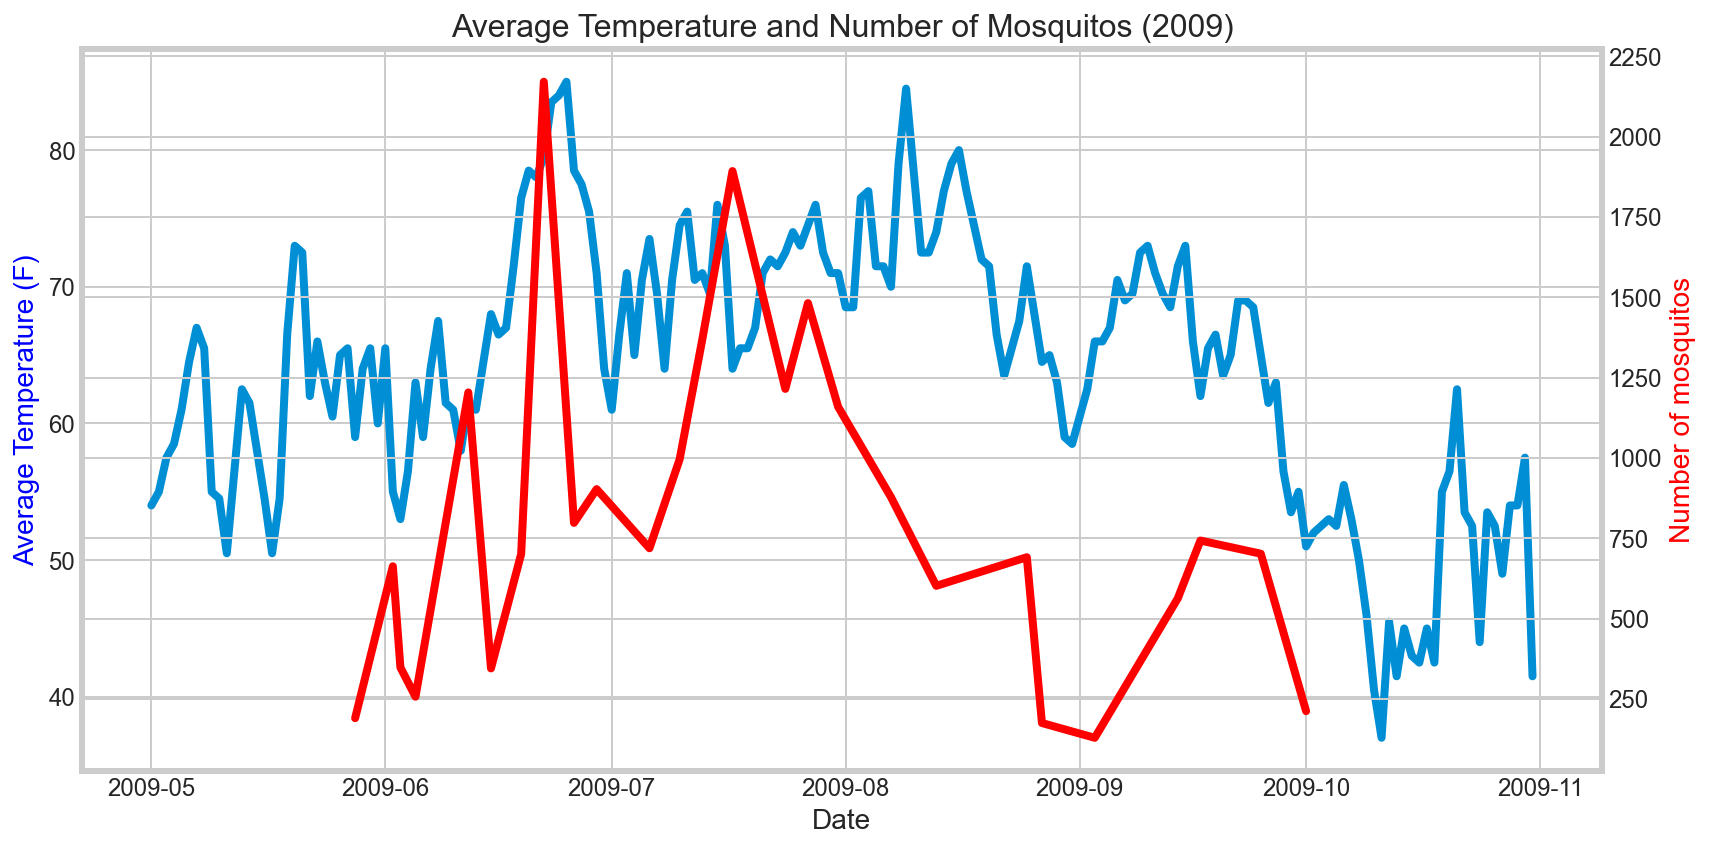

In [45]:
fig, ax1 = plt.subplots(figsize=(12,6))

mask_year = df_weather['year'] == 2009

sns.lineplot(x=df_weather[df_weather['year'] == 2009].date, y=df_weather[df_weather['year'] == 2009].tavg, ci=None, ax=ax1)
ax1.set_ylabel('Average Temperature (F)', color='blue', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.tick_params(labelsize=12)

mosquito_day = df_train[df_train['year'] == 2009].groupby(['date']).nummosquitos.sum()
df_mosquito_day = pd.DataFrame(mosquito_day)

ax2 = ax1.twinx()
sns.lineplot(x=df_mosquito_day.index, y=df_mosquito_day.nummosquitos, 
             ci=None, ax=ax2, color='r')
ax2.set_ylabel('Number of mosquitos', color='r', fontsize=14)
ax2.tick_params(labelsize=12)

plt.title('Average Temperature and Number of Mosquitos (2009)', fontsize=16)
fig.tight_layout()
plt.show()

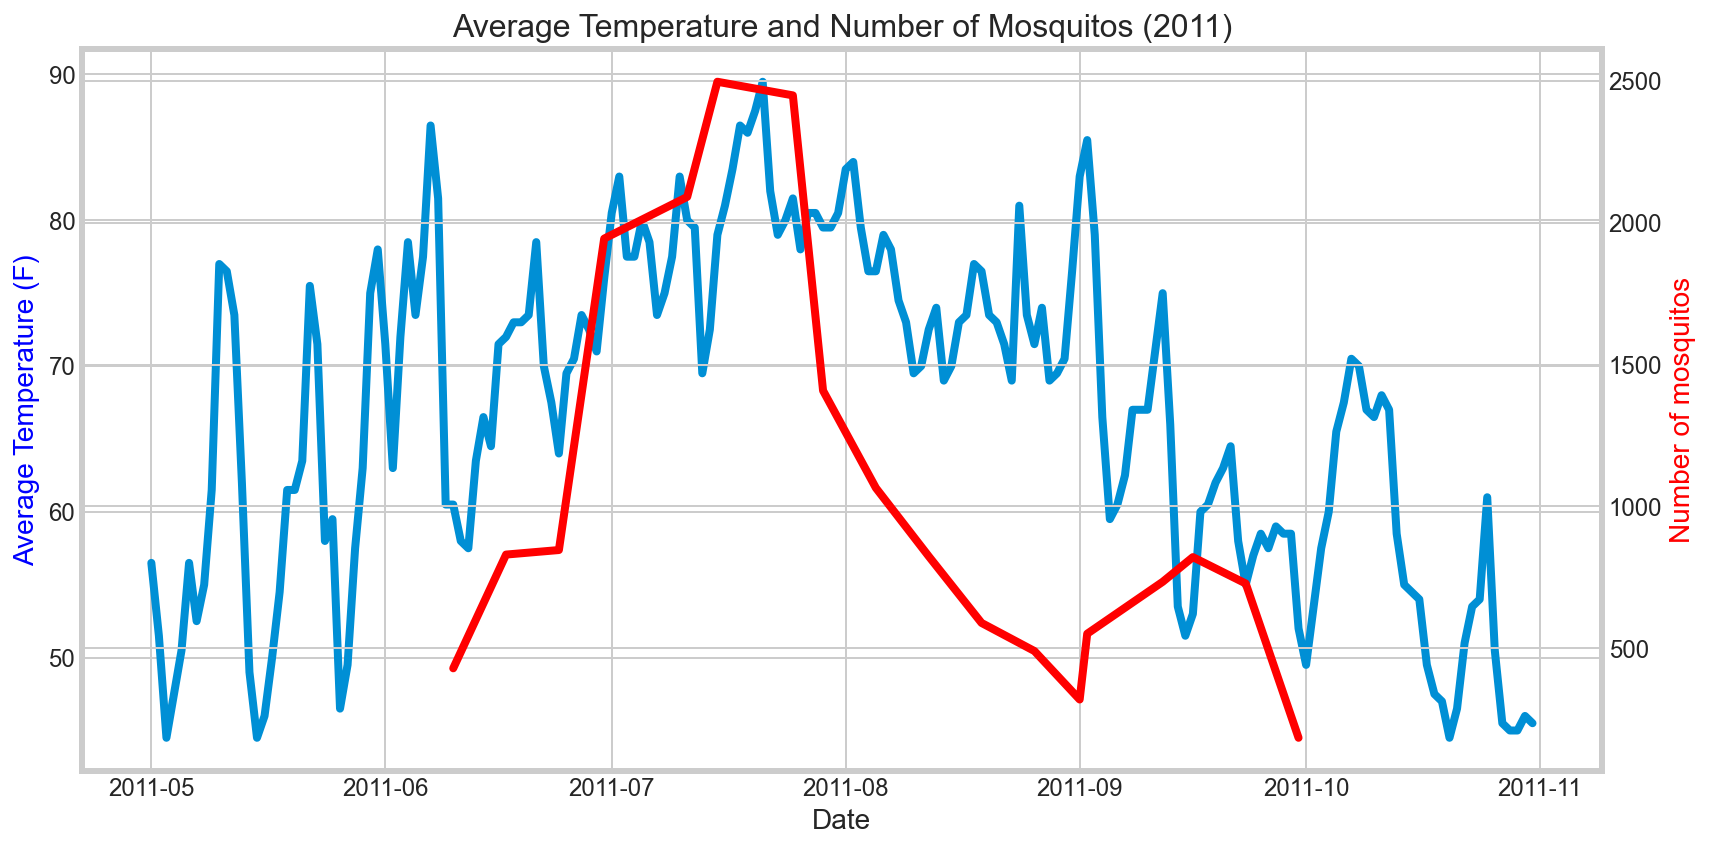

In [46]:
fig, ax1 = plt.subplots(figsize=(12,6))

mask_year = df_weather['year'] == 2011

sns.lineplot(x=df_weather[df_weather['year'] == 2011].date, y=df_weather[df_weather['year'] == 2011].tavg, ci=None, ax=ax1)
ax1.set_ylabel('Average Temperature (F)', color='blue', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.tick_params(labelsize=12)

mosquito_day = df_train[df_train['year'] == 2011].groupby(['date']).nummosquitos.sum()
df_mosquito_day = pd.DataFrame(mosquito_day)

ax2 = ax1.twinx()
sns.lineplot(x=df_mosquito_day.index, y=df_mosquito_day.nummosquitos, 
             ci=None, ax=ax2, color='r')
ax2.set_ylabel('Number of mosquitos', color='r', fontsize=14)
ax2.tick_params(labelsize=12)

plt.title('Average Temperature and Number of Mosquitos (2011)', fontsize=16)
fig.tight_layout()
plt.show()

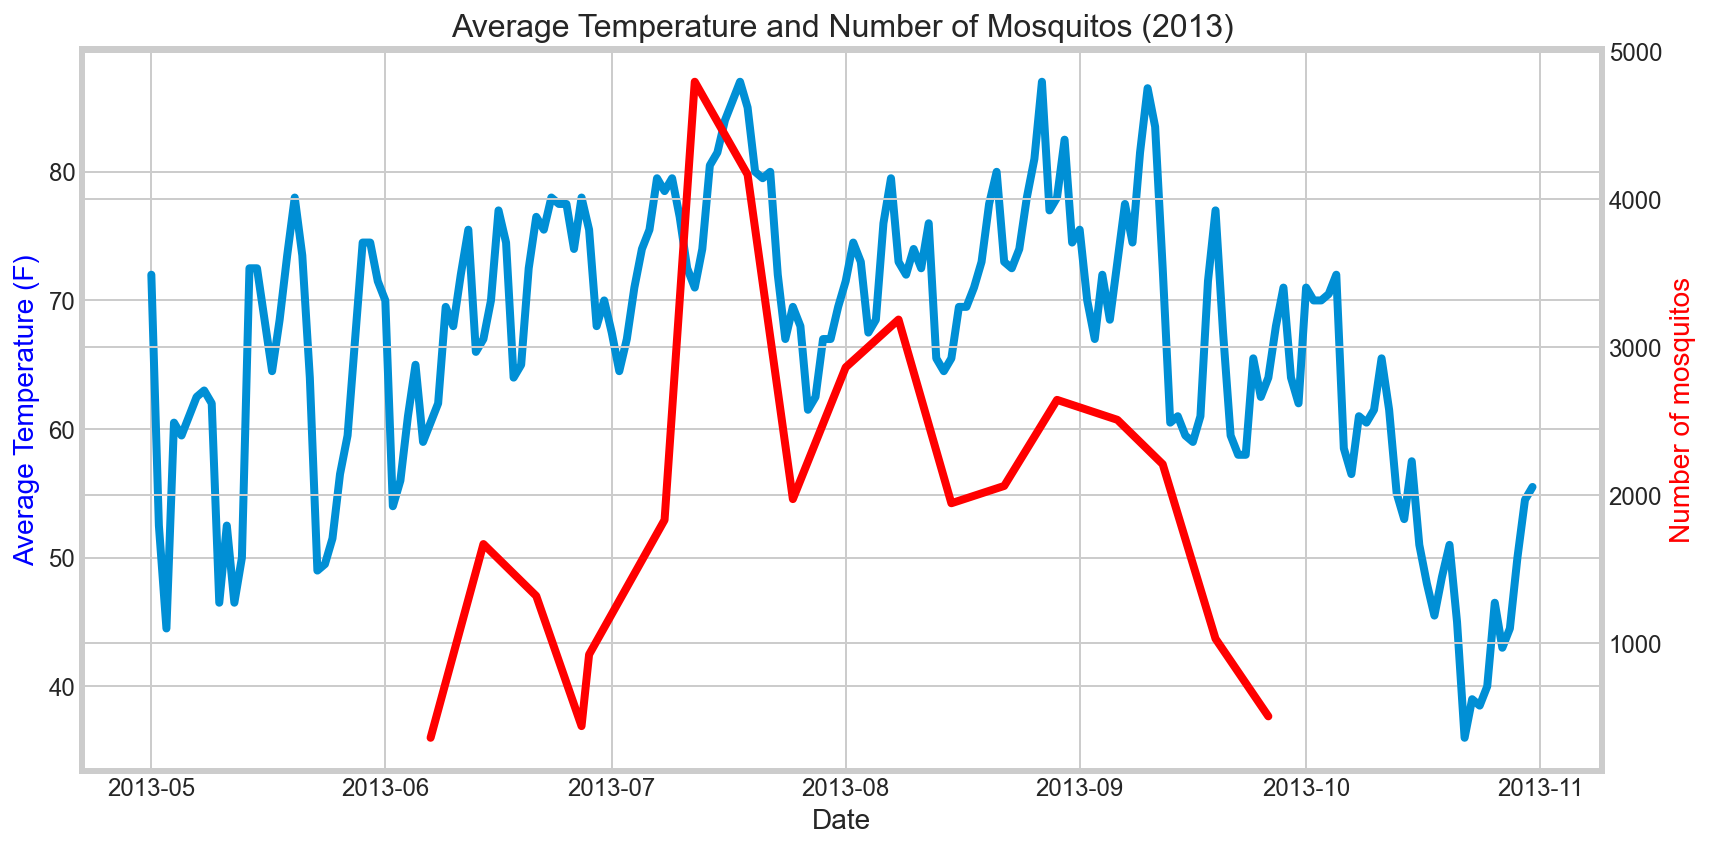

In [47]:
fig, ax1 = plt.subplots(figsize=(12,6))

mask_year = df_weather['year'] == 2013

sns.lineplot(x=df_weather[mask_year].date, y=df_weather[mask_year].tavg, ci=None, ax=ax1)
ax1.set_ylabel('Average Temperature (F)', color='blue', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.tick_params(labelsize=12)

mosquito_day = df_train[df_train['year'] == 2013].groupby(['date']).nummosquitos.sum()
df_mosquito_day = pd.DataFrame(mosquito_day)

ax2 = ax1.twinx()
sns.lineplot(x=df_mosquito_day.index, y=df_mosquito_day.nummosquitos, 
             ci=None, ax=ax2, color='r')
ax2.set_ylabel('Number of mosquitos', color='r', fontsize=14)
ax2.tick_params(labelsize=12)

plt.title('Average Temperature and Number of Mosquitos (2013)', fontsize=16)
fig.tight_layout()
plt.show()

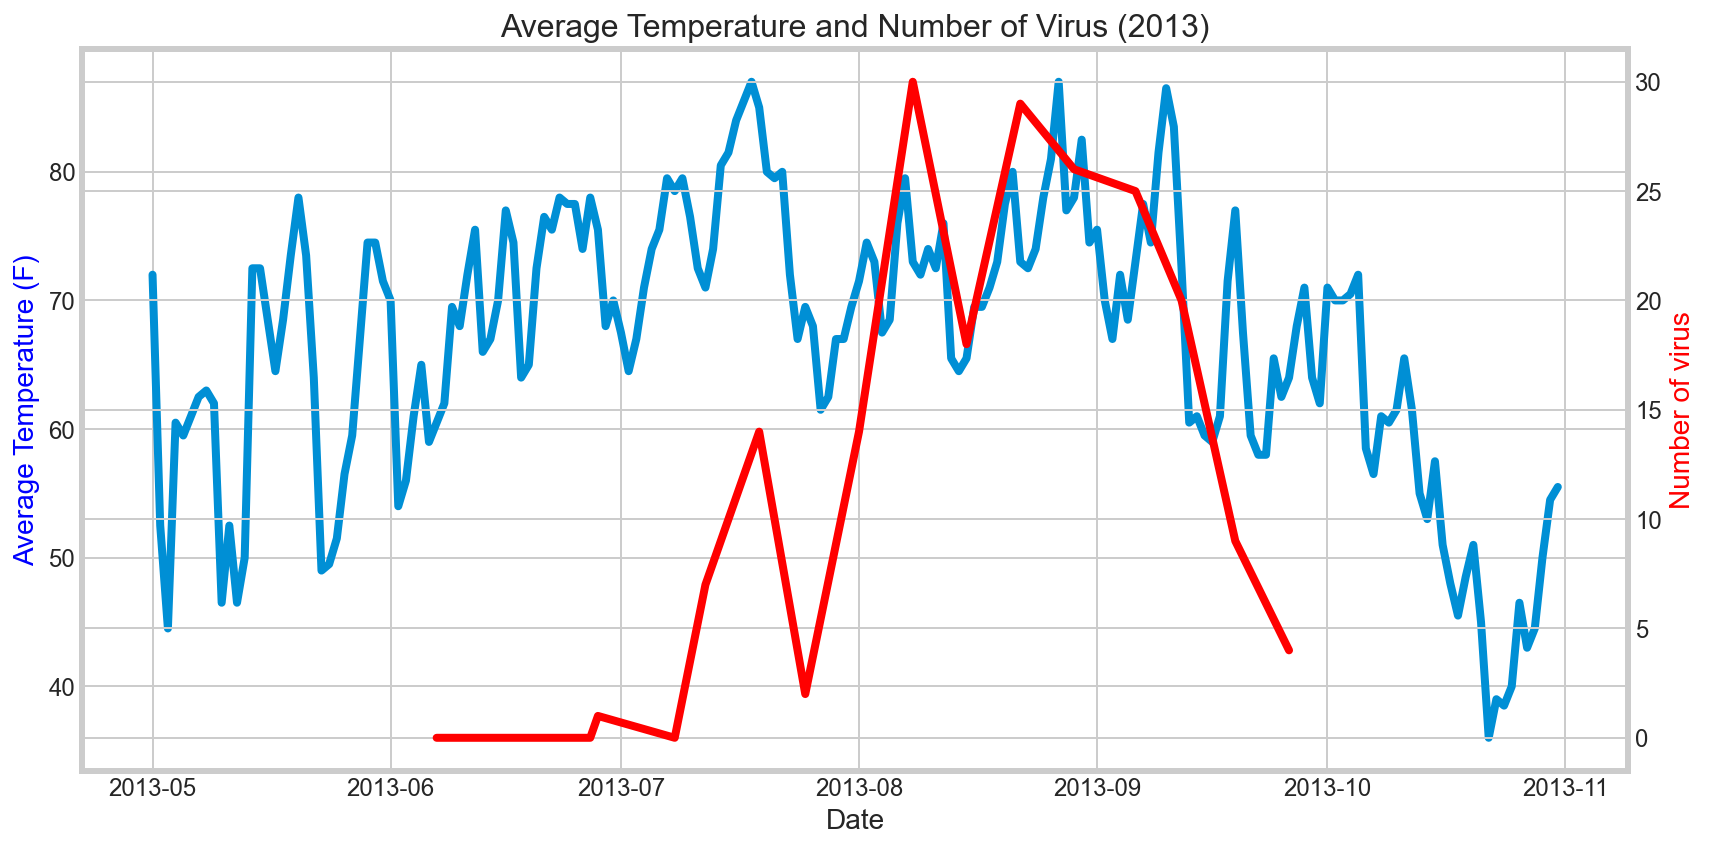

In [48]:
fig, ax1 = plt.subplots(figsize=(12,6))

mask_year = df_weather['year'] == 2013

sns.lineplot(x=df_weather[mask_year].date, y=df_weather[mask_year].tavg, ci=None, ax=ax1)
ax1.set_ylabel('Average Temperature (F)', color='blue', fontsize=14)
ax1.set_xlabel('Date', fontsize=14)
ax1.tick_params(labelsize=12)

wnv_day = df_train[df_train['year'] == 2013].groupby(['date']).wnvpresent.sum()
df_wmn_day = pd.DataFrame(wnv_day)

ax2 = ax1.twinx()
sns.lineplot(x=df_wmn_day.index, y=df_wmn_day.wnvpresent, 
             ci=None, ax=ax2, color='r')
ax2.set_ylabel('Number of virus', color='r', fontsize=14)
ax2.tick_params(labelsize=12)

plt.title('Average Temperature and Number of Virus (2013)', fontsize=16)
fig.tight_layout()
plt.show()

In [49]:
combined['date'] = combined.apply(combined_date, axis=1)
combined.head()

species  block           street  trap   latitude  longitude  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002  41.954690 -87.800991   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002  41.954690 -87.800991   
2          CULEX RESTUANS     62    N MANDELL AVE  T007  41.994991 -87.769279   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015  41.974089 -87.824812   
4          CULEX RESTUANS     79     W FOSTER AVE  T015  41.974089 -87.824812   

   nummosquitos  wnvpresent  year  month  ...  stnpressure sealevel  \
0             1           0  2007      5  ...        29.39    30.11   
1             1           0  2007      5  ...        29.39    30.11   
2             1           0  2007      5  ...        29.39    30.11   
3             1           0  2007      5  ...        29.39    30.11   
4             4           0  2007      5  ...        29.39    30.11   

   resultspeed  resultdir  avgspeed           sunrise_2            sunset_2  \
0          5.8         18       6.5 1900-01-01 04:21:00 1900-01-01 19:17:00   
1          5.8         18       6.5 1900-01-01 04:21:00 1900-01-01 19:17:00   
2          5.8         18       6.5 1900-01-01 04:21:00 1900-01-01 19:17:00   
3          5.8         18       6.5 1900-01-01 04:21:00 1900-01-01 19:17:00   
4          5.8         18       6.5 1900-01-01 04:21:00 1900-01-01 19:17:00   

         daylight  daylight_2       date  
0 0 days 14:56:00   14.933333 2007-05-29  
1 0 days 14:56:00   14.933333 2007-05-29  
2 0 days 14:56:00   14.933333 2007-05-29  
3 0 days 14:56:00   14.933333 2007-05-29  
4 0 days 14:56:00   14.933333 2007-05-29  

[5 rows x 34 columns]